# LIBRERIAS NECESARIAS

In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
plt.rcParams["grid.color"] = "k"  # Esto pone una cuadrícula con líneas de color negro
plt.rcParams["grid.alpha"] = 0.1  # Esto hace que las líneas de la cuadrícula sean muy transparentes



# LIMPIEZA E UNIÓN DE DATOS

In [2]:
import pandas as pd
import os

# Supón que df es tu DataFrame


brands = ['F', 'GM', 'TSLA', 'RACE', 'TM', 'HMC' ]
daily_variables = ['Open', 'Close', 'High', 'Low', 'Volume', 'MA1', 'MA2', 'Market Cap']

def cambia(s):
    if isinstance(s, str):
        if s=="-":
            s=0.0
        elif isinstance(s, str):
            s=float(s.replace(",","").replace("%",""))
    return s


def change_data(df, type):
    df.index.name = 'Date'
    df.index = pd.to_datetime(df.index)

    for c in df.columns:
        df[c]= df[c].map(cambia)
        df[c] = df[c].astype("float")

    if type == 2:
        print(df.isnull().sum().sum())
        print(df.shape[0] * df.shape[1])
        df = df.drop(df.index[:5])
        df = df.interpolate(method ='linear', limit_direction ='forward', axis = 0) # rellenar con el de atras
        df =  df.fillna(axis = 1, method = 'bfill')# rellenar con el de delante
    return df



dataframes = {}

for brand in brands:
    directory = os.path.abspath(f'DataSet/{brand}/')
    
    chart = pd.read_csv(f'{directory}/{brand}-chart.csv')


    chart = chart.set_index('Date')
    input_df = change_data(chart, 1)
    dataframes[brand] = input_df
    
    for filename in os.listdir(directory):
        
        input_df = pd.read_csv(f'{directory}/{filename}')

        if filename == f'{brand}-chart.csv':
            pass
            
        else:
            if filename == f'{brand}-market-cap.csv':
                input_df = input_df.set_index('Date')
                input_df = input_df.drop('% Change', axis = 1)
                print(filename)
                input_df = change_data(input_df, 2)

            else:
                input_df = input_df.T
                input_df.columns = input_df.iloc[0]
                input_df = input_df[1:]
                print(filename)
                input_df = change_data(input_df, 2)



            dataframes[brand] = dataframes[brand].merge(input_df, how='outer', left_index=True, right_index=True) 
    print(brand)
    
    dataframes[brand] = dataframes[brand].ffill().dropna()
    # Primero, crea una máscara booleana para las columnas que contienen algún cero
    mask = (dataframes[brand] != 0).all()

    # Luego, aplica esta máscara para mantener sólo las columnas donde todos los valores son distintos de cero
    dataframes[brand] = dataframes[brand].loc[:, mask]
        
    

    





F-balance-sheet-quarterly.csv
841
3520
F-cash-flow-statement-quarterly.csv
138
2289
F-income-statement-quarterly.csv
276
3630
F-market-cap.csv
0
6163
F-ratios-quarterly.csv
127
1320
F
GM-balance-sheet-quarterly.csv
46
1815
GM-cash-flow-statement-quarterly.csv
55
1100
GM-income-statement-quarterly.csv
77
1925
GM-market-cap.csv
0
3153
GM-ratios-quarterly.csv
64
660
GM
TSLA-balance-sheet-quarterly.csv
147
1972
TSLA-cash-flow-statement-quarterly.csv
116
1140
TSLA-income-statement-quarterly.csv
163
1856
TSLA-market-cap.csv
0
3252
TSLA-ratios-quarterly.csv
51
580
TSLA
RACE-balance-sheet-quarterly.csv
107
851
RACE-cash-flow-statement-quarterly.csv
49
720
RACE-income-statement-quarterly.csv
57
1152
RACE-market-cap.csv
0
1915
RACE-ratios-quarterly.csv
101
407
RACE
TM-balance-sheet-quarterly.csv
72
2263
TM-cash-flow-statement-quarterly.csv
274
1440
TM-income-statement-quarterly.csv
314
2232
TM-market-cap.csv
0
5580
TM-ratios-quarterly.csv
80
876
TM
HMC-balance-sheet-quarterly.csv
12
2728
HMC-cas

In [3]:
print(dataframes['GM'].shape[0] * dataframes['GM'].shape[1])

305500


In [4]:
for brand in brands:
    print(brand)
    print(dataframes[brand].shape)

        

F
(6770, 90)
GM
(3250, 94)
TSLA
(3349, 93)
RACE
(1886, 84)
TM
(5565, 90)
HMC
(5983, 91)


# TECHNICAL INDICATORS


In [4]:
import ta.momentum, ta.volatility, ta.volume, ta.trend
indicators = ['RSI', 'EMA14', 'EMA50', 'MACD', 'ADX', 'CMF', 'SO', 'LBOLLINGER', 'HBOLLINGER', 'FI']
daily_variables.extend(indicators)

print('Daily Variables ', daily_variables)

def add_techindicators(df):
    # RSI TECHNICAL INDICATOR - Empieza a los 14 días 
    df['RSI'] = ta.momentum.RSIIndicator(df['Close']).rsi()
    df['EMA14'] = ta.trend.EMAIndicator(df.Close).ema_indicator() #Exponential moving average 14 periods
    df['EMA50'] = ta.trend.EMAIndicator(df.Close, window = 50).ema_indicator()
    df['MACD'] = ta.trend.MACD(df.Close).macd()
    df['ADX'] = ta.trend.adx(df.High, df.Low, df.Close)
    df['CMF'] = ta.volume.ChaikinMoneyFlowIndicator(df.High, df.Low, df.Close, df.Volume).chaikin_money_flow()
    df['SO'] = ta.momentum.StochasticOscillator(df.High, df.Low, df.Close).stoch()
    df['LBOLLINGER'] = ta.volatility.BollingerBands(df.Close).bollinger_lband()
    df['HBOLLINGER'] = ta.volatility.BollingerBands(df.Close).bollinger_hband()
    df['FI'] = ta.volume.ForceIndexIndicator(df.Close, df.Volume).force_index() 
    return df

for brand in dataframes:
    df_ta =  add_techindicators(dataframes[brand])
    df_ta = df_ta.dropna() # los indicadores necesitan un  días previos para su computo, por lo que nos quedamos con aquellos que nos interesan
    dataframes[brand] = df_ta


dataframes['TSLA'].head()

Daily Variables  ['Open', 'Close', 'High', 'Low', 'Volume', 'MA1', 'MA2', 'Market Cap', 'RSI', 'EMA14', 'EMA50', 'MACD', 'ADX', 'CMF', 'SO', 'LBOLLINGER', 'HBOLLINGER', 'FI']


Open  Close   High    Low      Volume    MA1    MA2  \
Date                                                               
2011-06-23  1.813  1.847  1.848  1.747  17550000.0  1.822  1.707   
2011-06-24  1.843  1.838  1.865  1.817  54127500.0  1.826  1.709   
2011-06-27  1.849  1.831  1.885  1.821  27141000.0  1.829  1.711   
2011-06-28  1.853  1.874  1.883  1.845  13338000.0  1.832  1.714   
2011-06-29  1.900  1.886  1.939  1.871  21927000.0  1.837  1.716   

            Cash & Equivalents  Cash & Cash Equivalents  Cash Growth  ...  \
Date                                                                  ...   
2011-06-23         148532000.0              148532000.0       115.16  ...   
2011-06-24         148532000.0              148532000.0       115.16  ...   
2011-06-27         148532000.0              148532000.0       115.16  ...   
2011-06-28         148532000.0              148532000.0       115.16  ...   
2011-06-29         148532000.0              148532000.0       115.16  ...   

                  RSI     EMA14     EMA50      MACD        ADX       CMF  \
Date                                                                       
2011-06-23  50.826896  1.833404  1.815039 -0.007876  11.652633 -0.116861   
2011-06-24  50.047197  1.834017  1.815939 -0.006659  11.057050 -0.182871   
2011-06-27  49.412292  1.833615  1.816530 -0.006188  10.267743 -0.244178   
2011-06-28  53.329081  1.838999  1.818784 -0.002318   9.534816 -0.299533   
2011-06-29  54.390383  1.845266  1.821420  0.001697   9.526004 -0.287368   

                   SO  LBOLLINGER  HBOLLINGER             FI  
Date                                                          
2011-06-23  47.572816    1.720594    2.026206  189108.292875  
2011-06-24  49.285714    1.719534    2.014566   92500.322464  
2011-06-27  46.785714    1.719715    2.000485   52144.990683  
2011-06-28  62.142857    1.730345    1.976355  126629.134871  
2011-06-29  66.428571    1.730588    1.974612  146128.401318  

[5 rows x 103 columns]

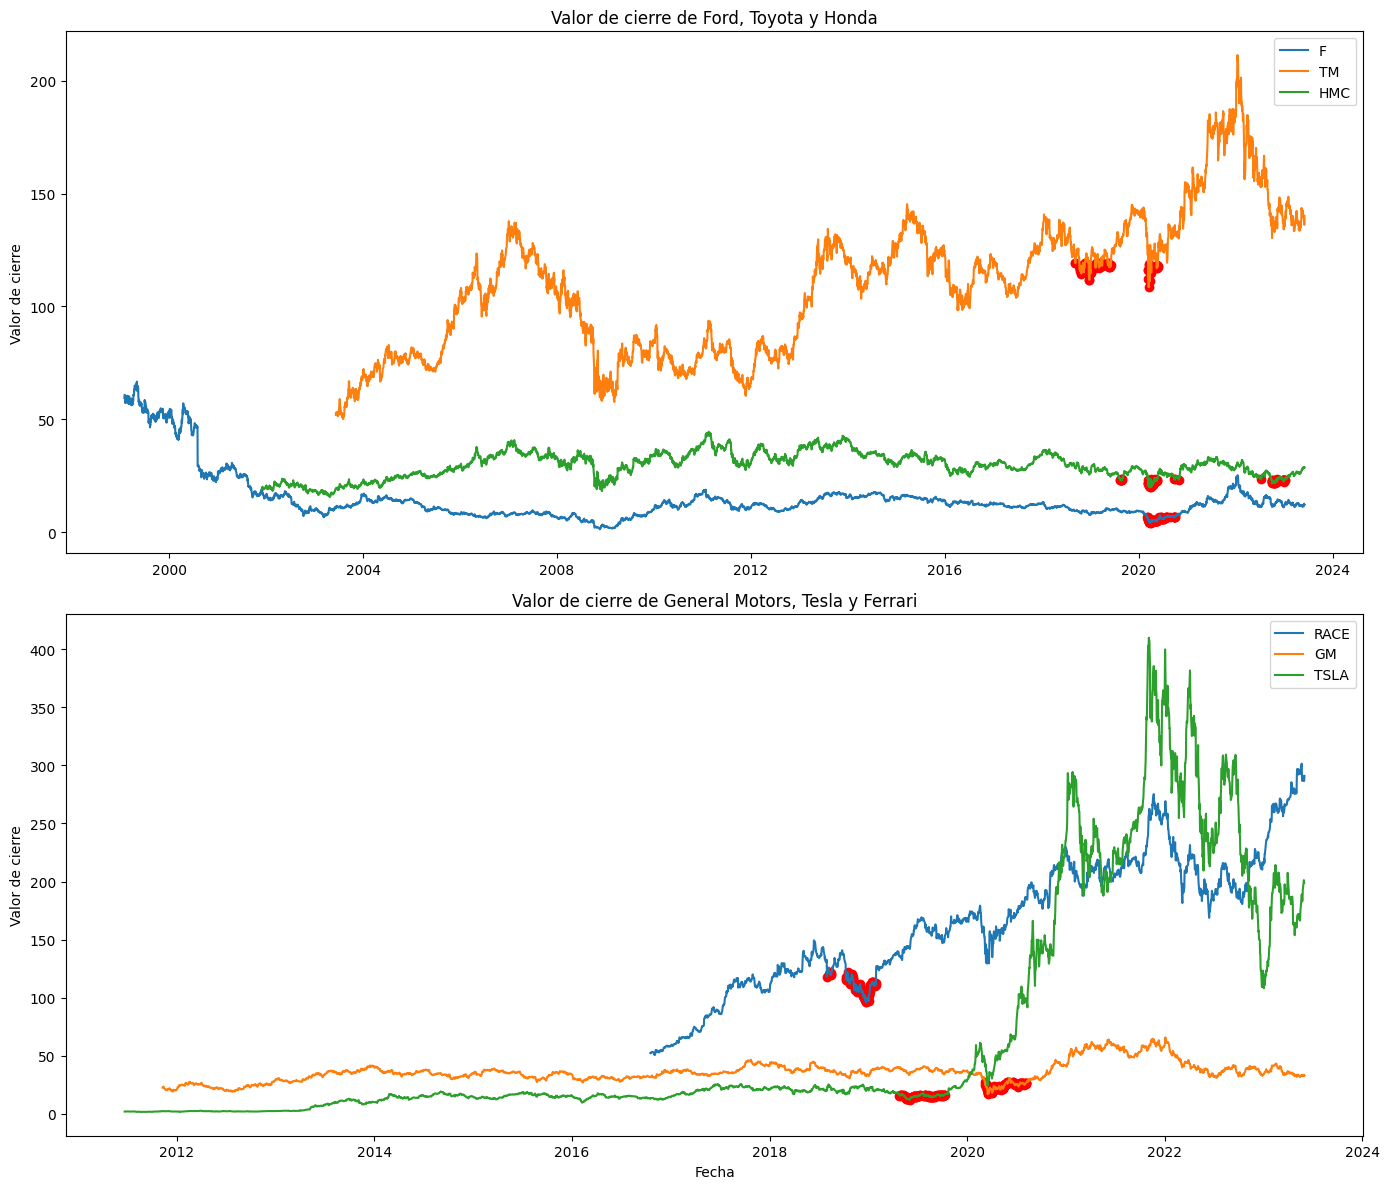

In [5]:
#import matplotlib.pyplot as plt
#plt.rcParams["grid.color"] = "k"   # Esto pondrá una cuadrícula con líneas de color negro
#plt.rcParams["grid.linestyle"] = ":"   # Esto cambiará el estilo de las líneas de la cuadrícula
#import seaborn as sns
#sns.set(style="whitegrid")
#plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['b', 'g', 'r', 'c', 'm', 'y', 'k'])

#sns.set_palette("deep")

# Definimos el tamaño de la figura
plt.figure(figsize=(14, 12))

# Creamos el primer subplot
plt.subplot(2, 1, 1)
# Recorremos cada dataframe y lo dibujamos
# Fecha actual
now = pd.to_datetime('today')
# Fecha de inicio de los últimos 14 años
start_date = now - pd.DateOffset(years=5)
for i in ['F', 'TM', 'HMC']:
   input_df = dataframes[i]
   # Ordena el dataframe por valor de cierre en orden ascendente y toma los 100 primeros
   low_points = input_df.loc[start_date:].sort_values(by='Close', ascending=True).head(100)
   
   # Dibuja la línea temporal del valor de cierre
   plt.plot(input_df.index, input_df['Close'], label=i)
   
   # Dibuja los puntos bajos como puntos de dispersión
   plt.scatter(low_points.index, low_points['Close'], color='red')

# Añadimos leyenda, título y etiquetas
plt.legend()
plt.title('Valor de cierre de Ford, Toyota y Honda')
plt.ylabel('Valor de cierre')

# Creamos el segundo subplot
plt.subplot(2, 1, 2)
# Recorremos cada dataframe y lo dibujamos
for i in ['RACE', 'GM', 'TSLA']:
   input_df = dataframes[i]
   # Ordena el dataframe por valor de cierre en orden ascendente y toma los 100 primeros
   low_points = input_df.loc[start_date:].sort_values(by='Close', ascending=True).head(100)
   
   # Dibuja la línea temporal del valor de cierre
   plt.plot(input_df.index, input_df['Close'], label=i)
   
   # Dibuja los puntos bajos como puntos de dispersión
   plt.scatter(low_points.index, low_points['Close'], color='red')

# Añadimos leyenda, título y etiquetas
plt.legend()
plt.title('Valor de cierre de General Motors, Tesla y Ferrari')
plt.xlabel('Fecha')
plt.ylabel('Valor de cierre')

# Mostramos la figura
plt.tight_layout()
plt.show()

OUTLIER REMOVAL
We only want to focus on the furthest values, so we do not want to lose a big amount of data

In [6]:
from scipy import stats

for brand in brands: 
   # 1. Calcula el z-score de cada elemento en cada columna
   z_scores = dataframes[brand].apply(stats.zscore)

   # 2. Determina el número de outliers en cada columna (un z-score absoluto de > 3 suele ser un indicador de outlier)
   outliers = z_scores > 3

   # 3. Ordena las columnas por el número de outliers
   outliers_count = outliers.sum().sort_values(ascending=False)

   # 4. Selecciona las primeras 10 columnas
   top_10_columns_with_outliers = outliers_count.head(10)

   print(brand, ' :\n',top_10_columns_with_outliers)

F  :
 Net Income Growth    390
MA2                  381
HBOLLINGER           366
MA1                  360
EMA50                348
Close                345
Open                 344
High                 343
Low                  343
EMA14                340
dtype: int64
GM  :
 Free Cash Flow Growth         136
Other Financing Activities    136
Market Cap Growth             127
Goodwill and Intangibles      118
PE Ratio                       76
Net Cash / Debt Growth         75
Free Cash Flow Per Share_x     75
Free Cash Flow Per Share_y     75
Free Cash Flow                 75
Other Expense / Income         74
dtype: int64
TSLA  :
 Share Issuance / Repurchase    148
Net Cash Flow                  148
Market Cap Growth              148
Revenue Growth (YoY)           129
Operating Cash Flow Growth      75
Financing Cash Flow             75
Free Cash Flow Growth           75
PE Ratio                        73
Shares Change                   69
Volume                          64
dtype: int64

In [7]:
for brand in brands:
    print(brand, dataframes[brand].shape)

F (6721, 100)
GM (3201, 104)
TSLA (3300, 103)
RACE (1837, 94)
TM (5516, 100)
HMC (5934, 101)


In [8]:
# Adding Target Value (days = f - scrap 1.1)
def target_value(df, column = 'Close', days = 7): #Consideramos longitud de una semana
   
   df["Target"] = df[column].shift(-days)
   df = df.dropna()

   return df

for brand in brands:
   dataframes[brand] = target_value(dataframes[brand])
   #dataframes[brand].to_csv(f'Merged_data/{brand}-merged.csv', mode = 'w')
   #dataframes[brand].to_excel(f'Merged_data/{brand}-merged.xlsx', 'w')

In [9]:
dataframes['TSLA']

Open    Close     High      Low       Volume      MA1      MA2  \
Date                                                                            
2011-06-23    1.813    1.847    1.848    1.747   17550000.0    1.822    1.707   
2011-06-24    1.843    1.838    1.865    1.817   54127500.0    1.826    1.709   
2011-06-27    1.849    1.831    1.885    1.821   27141000.0    1.829    1.711   
2011-06-28    1.853    1.874    1.883    1.845   13338000.0    1.832    1.714   
2011-06-29    1.900    1.886    1.939    1.871   21927000.0    1.837    1.716   
...             ...      ...      ...      ...          ...      ...      ...   
2023-05-15  167.655  166.350  169.760  164.550  105592510.0  178.732  205.394   
2023-05-16  165.650  166.520  169.518  164.350   98288792.0  178.186  204.741   
2023-05-17  168.410  173.860  174.500  167.185  125473558.0  177.909  204.124   
2023-05-18  174.220  176.890  177.060  172.450  109520332.0  177.807  203.506   
2023-05-19  177.170  180.140  181.950  176.310  136196668.0  177.952  202.869   

            Cash & Equivalents  Cash & Cash Equivalents  Cash Growth  ...  \
Date                                                                  ...   
2011-06-23        1.485320e+08             1.485320e+08       115.16  ...   
2011-06-24        1.485320e+08             1.485320e+08       115.16  ...   
2011-06-27        1.485320e+08             1.485320e+08       115.16  ...   
2011-06-28        1.485320e+08             1.485320e+08       115.16  ...   
2011-06-29        1.485320e+08             1.485320e+08       115.16  ...   
...                        ...                      ...          ...  ...   
2023-05-15        1.757600e+10             1.770700e+10        -8.65  ...   
2023-05-16        1.757600e+10             1.770700e+10        -8.65  ...   
2023-05-17        1.757600e+10             1.770700e+10        -8.65  ...   
2023-05-18        1.757600e+10             1.770700e+10        -8.65  ...   
2023-05-19        1.757600e+10             1.770700e+10        -8.65  ...   

                 EMA14       EMA50      MACD        ADX       CMF         SO  \
Date                                                                           
2011-06-23    1.833404    1.815039 -0.007876  11.652633 -0.116861  47.572816   
2011-06-24    1.834017    1.815939 -0.006659  11.057050 -0.182871  49.285714   
2011-06-27    1.833615    1.816530 -0.006188  10.267743 -0.244178  46.785714   
2011-06-28    1.838999    1.818784 -0.002318   9.534816 -0.299533  62.142857   
2011-06-29    1.845266    1.821420  0.001697   9.526004 -0.287368  66.428571   
...                ...         ...       ...        ...       ...        ...   
2023-05-15  168.045276  175.227758 -3.284344  18.048384 -0.058844  55.897641   
2023-05-16  167.841906  174.886278 -3.140420  17.103535 -0.041071  56.577369   
2023-05-17  168.644318  174.846031 -2.406344  17.020796  0.000571  82.452642   
2023-05-18  169.743743  174.926187 -1.562082  17.308706  0.085128  97.358491   
2023-05-19  171.129910  175.130650 -0.623561  18.202486  0.073683  92.137272   

            LBOLLINGER  HBOLLINGER            FI   Target  
Date                                                       
2011-06-23    1.720594    2.026206  1.891083e+05    1.943  
2011-06-24    1.719534    2.014566  9.250032e+04    1.931  
2011-06-27    1.719715    2.000485  5.214499e+04    1.982  
2011-06-28    1.730345    1.976355  1.266291e+05    1.921  
2011-06-29    1.730588    1.974612  1.461284e+05    1.890  
...                ...         ...           ...      ...  
2023-05-15  152.122155  180.311845 -7.471907e+07  182.900  
2023-05-16  153.923692  176.731308 -6.165790e+07  184.470  
2023-05-17  155.113458  174.868542  7.871836e+07  193.170  
2023-05-18  154.588695  176.783305  1.148795e+08  201.160  
2023-05-19  153.687831  179.190169  1.617023e+08  198.820  

[3293 rows x 104 columns]

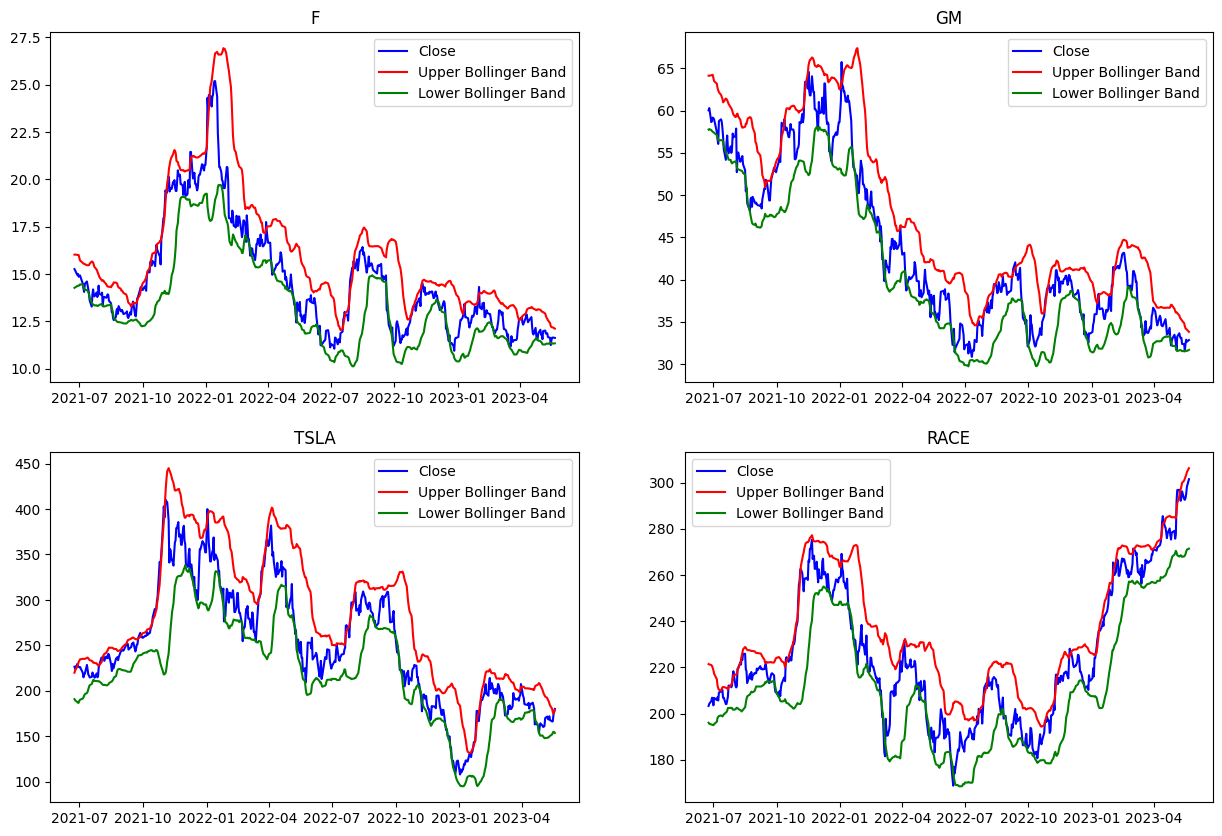

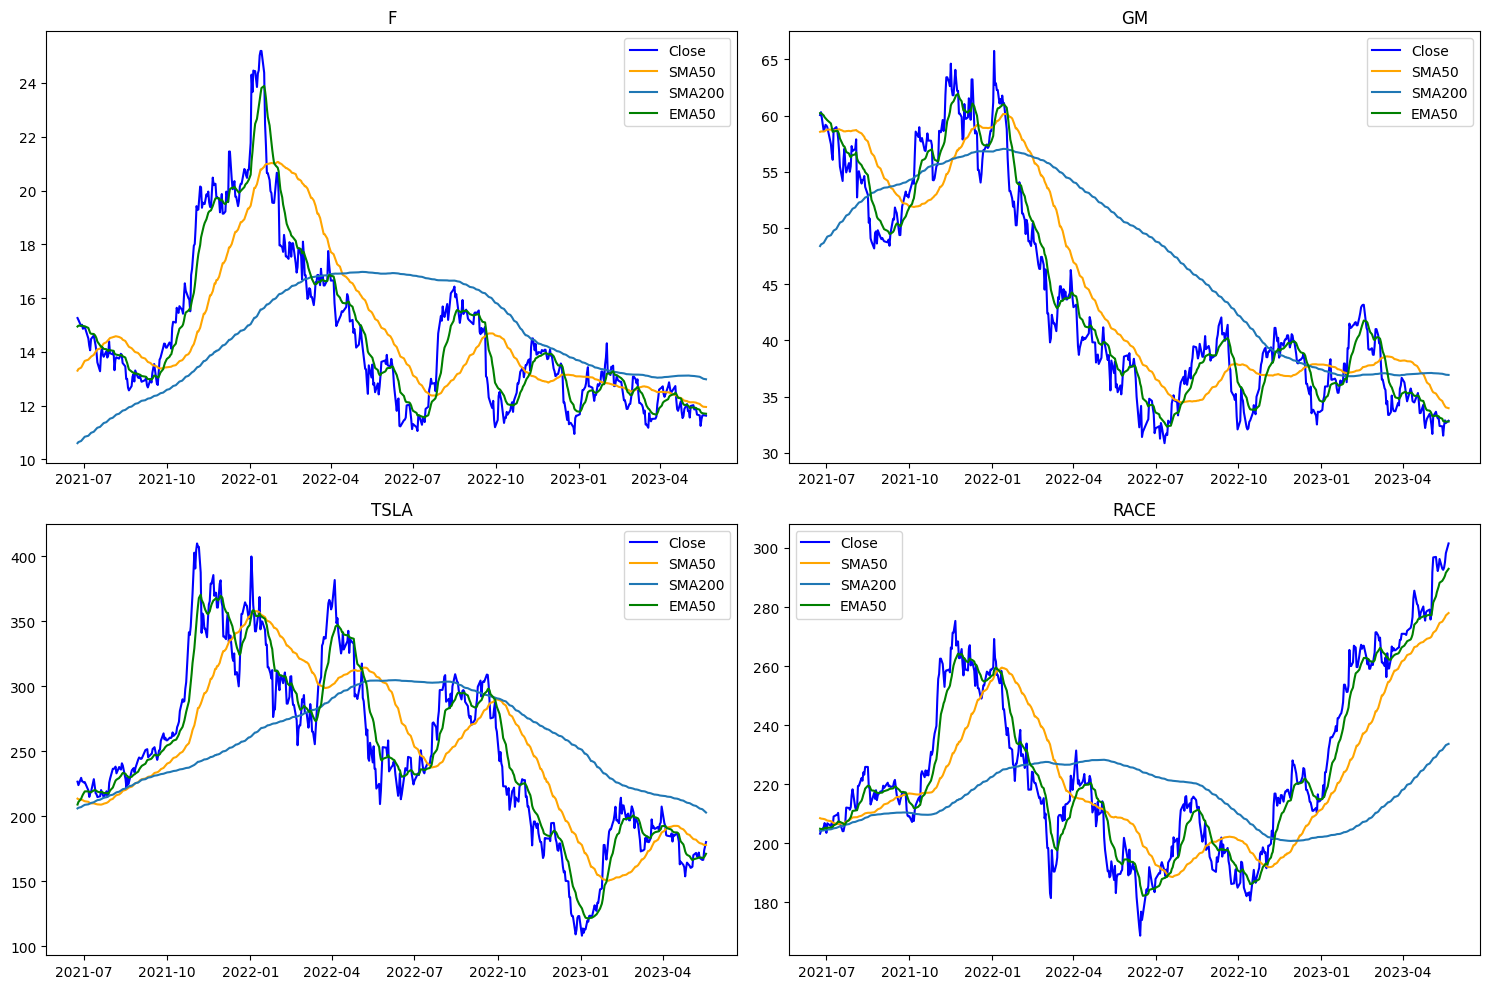

In [10]:
# Crea una nueva figura con 4 subplots (2 filas, 2 columnas)
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig2, axs2 = plt.subplots(2, 2, figsize=(15, 10))

# Aplanamos los axes para facilitar su manejo
axs = axs.ravel()
axs2 = axs2.ravel()
# Fecha de corte para los últimos 5 años
fecha_corte = pd.Timestamp.now() - pd.DateOffset(years=2)

# Recorremos la lista de dataframes y los plots correspondientes
for i, brand in enumerate(brands[:4]):
    # Plot 'Close'
    input_df = dataframes[brand]
    # Bollinger
    axs[i].plot(input_df[input_df.index >= fecha_corte].index, input_df[input_df.index >= fecha_corte]['Close'], label='Close', color='blue')

    # Plot 'HBollinger'
    axs[i].plot(input_df[input_df.index >= fecha_corte].index, input_df[input_df.index >= fecha_corte]['HBOLLINGER'], label='Upper Bollinger Band', color='red')

    # Plot 'LBollinger'
    axs[i].plot(input_df[input_df.index >= fecha_corte].index, input_df[input_df.index >= fecha_corte]['LBOLLINGER'], label='Lower Bollinger Band', color='green')

    #SMA

    axs2[i].plot(input_df[input_df.index >= fecha_corte].index, input_df[input_df.index >= fecha_corte]['Close'], label='Close' , color='blue')

    # Plot 'HBollinger'
    axs2[i].plot(input_df[input_df.index >= fecha_corte].index, input_df[input_df.index >= fecha_corte]['MA1'], label='SMA50', color='orange')

    # Plot 'LBollinger'
    axs2[i].plot(input_df[input_df.index >= fecha_corte].index, input_df[input_df.index >= fecha_corte]['MA2'], label='SMA200')

    #axs2[i].plot(df[df.index >= fecha_corte].index, df[df.index >= fecha_corte]['EMA14'], label='EMA14', color = 'black')

    axs2[i].plot(input_df[input_df.index >= fecha_corte].index, input_df[input_df.index >= fecha_corte]['EMA14'], label='EMA50', color = 'green')


    # Configuramos el título y la leyenda
    axs[i].set_title(brands[i])
    axs[i].legend()

    axs2[i].set_title(brands[i])
    axs2[i].legend()

# Ajustamos el espacio entre los subplots para evitar que se solapen
plt.tight_layout()

# Mostramos la figura
plt.show()

Visualización de estos indicadores técnicos

In [11]:
from pandas.tseries.offsets import QuarterEnd

def get_previous_quarter_value(date, series):
    previous_quarter_date = date - QuarterEnd()
    return series.get(previous_quarter_date, default=np.nan)


In [12]:
dataframes_lagged = {}

for brand in brands:
    
    df_lagged = dataframes[brand].copy()
    # Lags para las variables en 'daily_variables'
    daily_lags = range(1, 21)  # lags del 1 al 14
    for col in daily_variables:
        for lag in daily_lags:
            df_lagged[f'{col}_lag{lag}'] = df_lagged[col].shift(lag)

    # Lags para la variable 'Target'
    target_lags = range(7, 18)  # lags del 7 al 10
    for lag in target_lags:
        df_lagged[f'Target_lag{lag}'] = df_lagged['Target'].shift(lag)

    # Lags para el resto de las variables (exceptuando 'Target', 'Nominal_Close', 'Nominal_Target' y las 'daily_variables')
    quarterly_variables = [col for col in df_lagged.columns if col not in ['Target', 'Nominal_Close', 'Nominal_Target'] + daily_variables]
    for col in quarterly_variables:
        for lag in [1, 2]:  # Dos lags, correspondientes a los dos trimestres anteriores
            df_lagged[f'{col}_lag{lag}'] = df_lagged[col].index.to_series().apply(lambda date: get_previous_quarter_value(date - QuarterEnd(n=lag), df_lagged[col]))

    # Elimina las filas con NaNs que se hayan podido crear al obtener los lags
    df_lagged = df_lagged.dropna()
    dataframes_lagged[brand] = df_lagged

    df_lagged.to_excel(f'Lags/Non_Stationary/{brand}_lagged_non_stationary.xlsx', 'w')
    df_lagged.to_csv(f'Lags/Non_Stationary/{brand}_lagged_non_stationary.csv', mode = 'w')




OUTLIER REMOVAL

# STATIONARITY STUDY
The fact that non-stationarity might result in incorrect or misleading results is another justification for the necessity of time series being stationary before analysis. As an illustration, a non-stationary time series could give the impression that there is a high connection between two variables, but in reality, the correlation is only there because of a trend or a seasonal element in the data.

Stationarity -> mean cte and autocorrelation function independent fromt time (implies var cte)

Most used methods to studuy stationarity:

Augmented Dickey-Fuller test (ADF).

Kwatkowski-Phillips-Schmidt-Shin test (KPSS) can be used to check for stationarity.

Examining the time series plot visually and breaking it down into its trend, seasonal, and residual components.

In [13]:
dataframes['F'].columns

Index(['Open', 'Close', 'High', 'Low', 'Volume', 'MA1', 'MA2',
       'Cash & Equivalents', 'Short-Term Investments',
       'Cash & Cash Equivalents',
       ...
       'EMA14', 'EMA50', 'MACD', 'ADX', 'CMF', 'SO', 'LBOLLINGER',
       'HBOLLINGER', 'FI', 'Target'],
      dtype='object', length=101)

In [14]:
from arch.unitroot import ADF
from arch.unitroot import DFGLS
from arch.unitroot import PhillipsPerron
from arch.unitroot import KPSS # Hipotesis Nula -> Es estacionario / No nula -> No estacionario
import statsmodels.api as sm # sm.tsa.stattools.kpss(series, regression='ct').pvalue
# Si el p-valor es menor que el nivel de significancia, se rechaza la nula 

def plotValues(values, name):
    fig, ax = plt.subplots()
    
    x = np.arange(len(values))
    ax.scatter(x, values['PValue_ADF'], color='r', label='ADF')
    ax.scatter(x, values['PValue_DFGLS'], color='g', label='DFGLS')
    ax.scatter(x, values['PValue_PP'], color='b', label='PhillipsPerron')
    ax.scatter(x, values['PValue_KPSS'], color='y', label='KPSS')
    ax.scatter(x, values['PValue_Mean'], color='black', label='Mean')
    ax.set_xticks(x)
    ax.set_xticklabels(values.Index, rotation=90)
    ax.set_ylabel("p_value")
    ax.set_xlabel(name)
    ax.set(ylim=(0,1))
    plt.grid()
    plt.legend()
    plt.show()


def calculaEstacionareidad(df):
    header = df.columns
    test = []
    non_stationary_variables = []
    for i in range(0,len(header)):
        series = df[header[i]]
        p_values = {}
        # Estudiar la hipotesis nula 
        # Hacemos catch de las excepciones, ya que tenemos columnas con valores muy semejantes (localmente constante) en el tiempo con lo que
        #  al hacer la prueba de raíz unitaria porque la matriz del regresor en la regresión es singular.
        # No funciona ni cambiando el rango de rezagos máximos, asi que capturamos con un nan
        try:
            p_values['PValue_ADF'] = ADF(series).pvalue
        except: 
            p_values['PValue_ADF'] = np.nan
        try:
            p_values['PValue_DFGLS'] = DFGLS(series).pvalue
        except:
            p_values['PValue_DFGLS'] = np.nan
        try:
            p_values['PValue_KPSS'] = KPSS(series).pvalue # can return nan
        except:
            p_values['PValue_KPSS'] = np.nan
        try:
            p_values['PValue_PP'] = PhillipsPerron(series).pvalue
        except:
            p_values['PValue_PP'] = np.nan

        p_values_same_hipothesis = list(p_values.values())
        if p_values['PValue_ADF'] >= 0.05: # nivel de significancia escogido -> No se rechaza H0 -> No es estacionario
            non_stationary_variables.append(header[i])
        l = list(p_values.values())
        l.insert(0, header[i])
        test.append(l)


    columns = list(p_values.keys())
    columns.insert(0, 'Index')
    result_df = pd.DataFrame(test, columns=columns)
    return result_df, non_stationary_variables

non_stationary_variables = {} # Dict with brands as keys and non stationary variables

for brand in brands:
    print(brand)
    dataframe_pvalues, variables = calculaEstacionareidad(dataframes[brand])
    #dataframe_pvalues.to_excel(f'Estacionaridad/{brand}_first_view_stationarity_results.xlsx', 'w')
    print(variables)
    non_stationary_variables[brand] = variables


# SE OBSERVA QUE NINGUNA COLUMNA CONTENIENDO RATIOS ES NO ESTACIONARIA, COMO ERA DE ESPERAR 

F
['Cash & Equivalents', 'Short-Term Investments', 'Cash & Cash Equivalents', 'Inventory', 'Other Current Assets', 'Total Current Assets', 'Property, Plant & Equipment', 'Long-Term Investments', 'Other Long-Term Assets', 'Current Debt', 'Total Current Liabilities', 'Long-Term Debt', 'Other Long-Term Liabilities', 'Common Stock', 'Retained Earnings', 'Comprehensive Income', "Shareholders' Equity", 'Net Cash / Debt', 'Net Cash Per Share', 'Working Capital', 'Book Value Per Share', 'Operating Expenses', 'Other Expense / Income', 'Net Income Growth', 'Shares Outstanding (Basic)', 'Shares Outstanding (Diluted)', 'Market Cap', 'Market Capitalization', 'PS Ratio', 'Current Ratio']
GM
['Open', 'Close', 'High', 'Low', 'Short-Term Investments', 'Cash & Cash Equivalents', 'Inventory', 'Property, Plant & Equipment', 'Long-Term Investments', 'Other Long-Term Assets', 'Total Long-Term Assets', 'Total Assets', 'Accounts Payable', 'Current Debt', 'Total Current Liabilities', 'Other Current Liabilities

In [15]:
print(variables)

['MA2', 'Debt Growth', 'Book Value Per Share', 'Financing Cash Flow', 'Shares Outstanding (Basic)', 'Gross Margin', 'PS Ratio', 'PB Ratio', 'Debt / Equity Ratio']


In [16]:
non_stationary_variables

{'F': ['Cash & Equivalents',
  'Short-Term Investments',
  'Cash & Cash Equivalents',
  'Inventory',
  'Other Current Assets',
  'Total Current Assets',
  'Property, Plant & Equipment',
  'Long-Term Investments',
  'Other Long-Term Assets',
  'Current Debt',
  'Total Current Liabilities',
  'Long-Term Debt',
  'Other Long-Term Liabilities',
  'Common Stock',
  'Retained Earnings',
  'Comprehensive Income',
  "Shareholders' Equity",
  'Net Cash / Debt',
  'Net Cash Per Share',
  'Working Capital',
  'Book Value Per Share',
  'Operating Expenses',
  'Other Expense / Income',
  'Net Income Growth',
  'Shares Outstanding (Basic)',
  'Shares Outstanding (Diluted)',
  'Market Cap',
  'Market Capitalization',
  'PS Ratio',
  'Current Ratio'],
 'GM': ['Open',
  'Close',
  'High',
  'Low',
  'Short-Term Investments',
  'Cash & Cash Equivalents',
  'Inventory',
  'Property, Plant & Equipment',
  'Long-Term Investments',
  'Other Long-Term Assets',
  'Total Long-Term Assets',
  'Total Assets',
  

Proceed to transform our data to stationary

2 kinds of processes:
- Maths:
   - Logaritmic tranformation (used for prices)
   - Power transform
   - Box - Cox
- Differenciating:
   - 1 order : Today minus yerterday
   - 2 order: the same to the first order
   ...




https://analyzingalpha.com/make-time-series-stationary-python

In [17]:
def log_transform(x):
    if x < 0:
        return -np.log(-x)
    else:
        return np.log(x)
def preparar_log(df1):
   column_list = list(df1.columns) # obtienes una lista de todas las columnas
   column_list.remove('Target')
   
   df1['Nominal_Close'] = df1['Close'].copy()  # So we can obtain the real value after
   df1[column_list] = df1[column_list].applymap(log_transform)
   return df1

In [57]:
stationary_dataframes = {}
stationary_log_dataframes = {}

def log_transform(x):
    if x < 0:
        return -np.log(-x)
    else:
        return np.log(x)

def to_stationary(input_df, variables, log = False):
    df1 = input_df.copy()
    headers = list(input_df.columns)
    headers.remove('SO')
    df1['Nominal_Close'] = df1['Close'].copy()  # So we can obtain the real value after
    if log == True:
        df1[variables] = df1[variables].applymap(log_transform)
    for header in headers:
        s = df1[header]
        if header in daily_variables:
            if log:
                s_pct_change = s.diff()
            else:
                s_pct_change = s.pct_change()
        elif header == 'Target':
            if log:
                s_pct_change = s.diff(periods = 7)
            else:
                s_pct_change = s.pct_change(periods = 7)
        else:
            # Agrupa por trimestre tomando cualquier valor
            s_quarterly = s.resample('Q').first()  # 'Q' es la frecuencia para los trimestres

            # Realiza el cambio porcentual
            if log:
                s_quarterly_pct_change = s_quarterly.diff()
            else:
                s_quarterly_pct_change = s_quarterly.pct_change()

            # Regresa a la frecuencia original
            s_pct_change = s_quarterly_pct_change.resample('D').pad()  # 'D' es la frecuencia para los días
            
        df1[header] = s_pct_change

    df1 = df1.dropna()
    
    return df1

non_stationary_variables2 = {}
for brand in brands:
    print(brand)
    for log in [True, False]:
        print('Log', log)
        if log: 
            stationary_log_dataframes[brand] = to_stationary(dataframes[brand], non_stationary_variables[brand], log = log)
            dataframe_pvalues, variables = calculaEstacionareidad(stationary_log_dataframes[brand])
            print(variables)

        else:
            stationary_dataframes[brand] = to_stationary(dataframes[brand], non_stationary_variables[brand], log = log)
            dataframe_pvalues, variables = calculaEstacionareidad(stationary_dataframes[brand])
            #dataframe_pvalues.to_excel(f'Estacionaridad/{brand}_adjusted_stationary_results.xlsx', 'w')
            print(variables)
            non_stationary_variables2[brand] = variables
    



F
Log True
[]
Log False
[]
GM
Log True
['MA2', 'Nominal_Close']
Log False
['Nominal_Close']
TSLA
Log True
['MA2', 'Nominal_Close']
Log False
['MA2', 'Nominal_Close']
RACE
Log True
['MA2', 'Property, Plant & Equipment', 'Goodwill and Intangibles', 'Nominal_Close']
Log False
['MA2', 'Property, Plant & Equipment', 'Goodwill and Intangibles', 'Nominal_Close']
TM
Log True
['Nominal_Close']
Log False
['Nominal_Close']
HMC
Log True
[]
Log False
[]


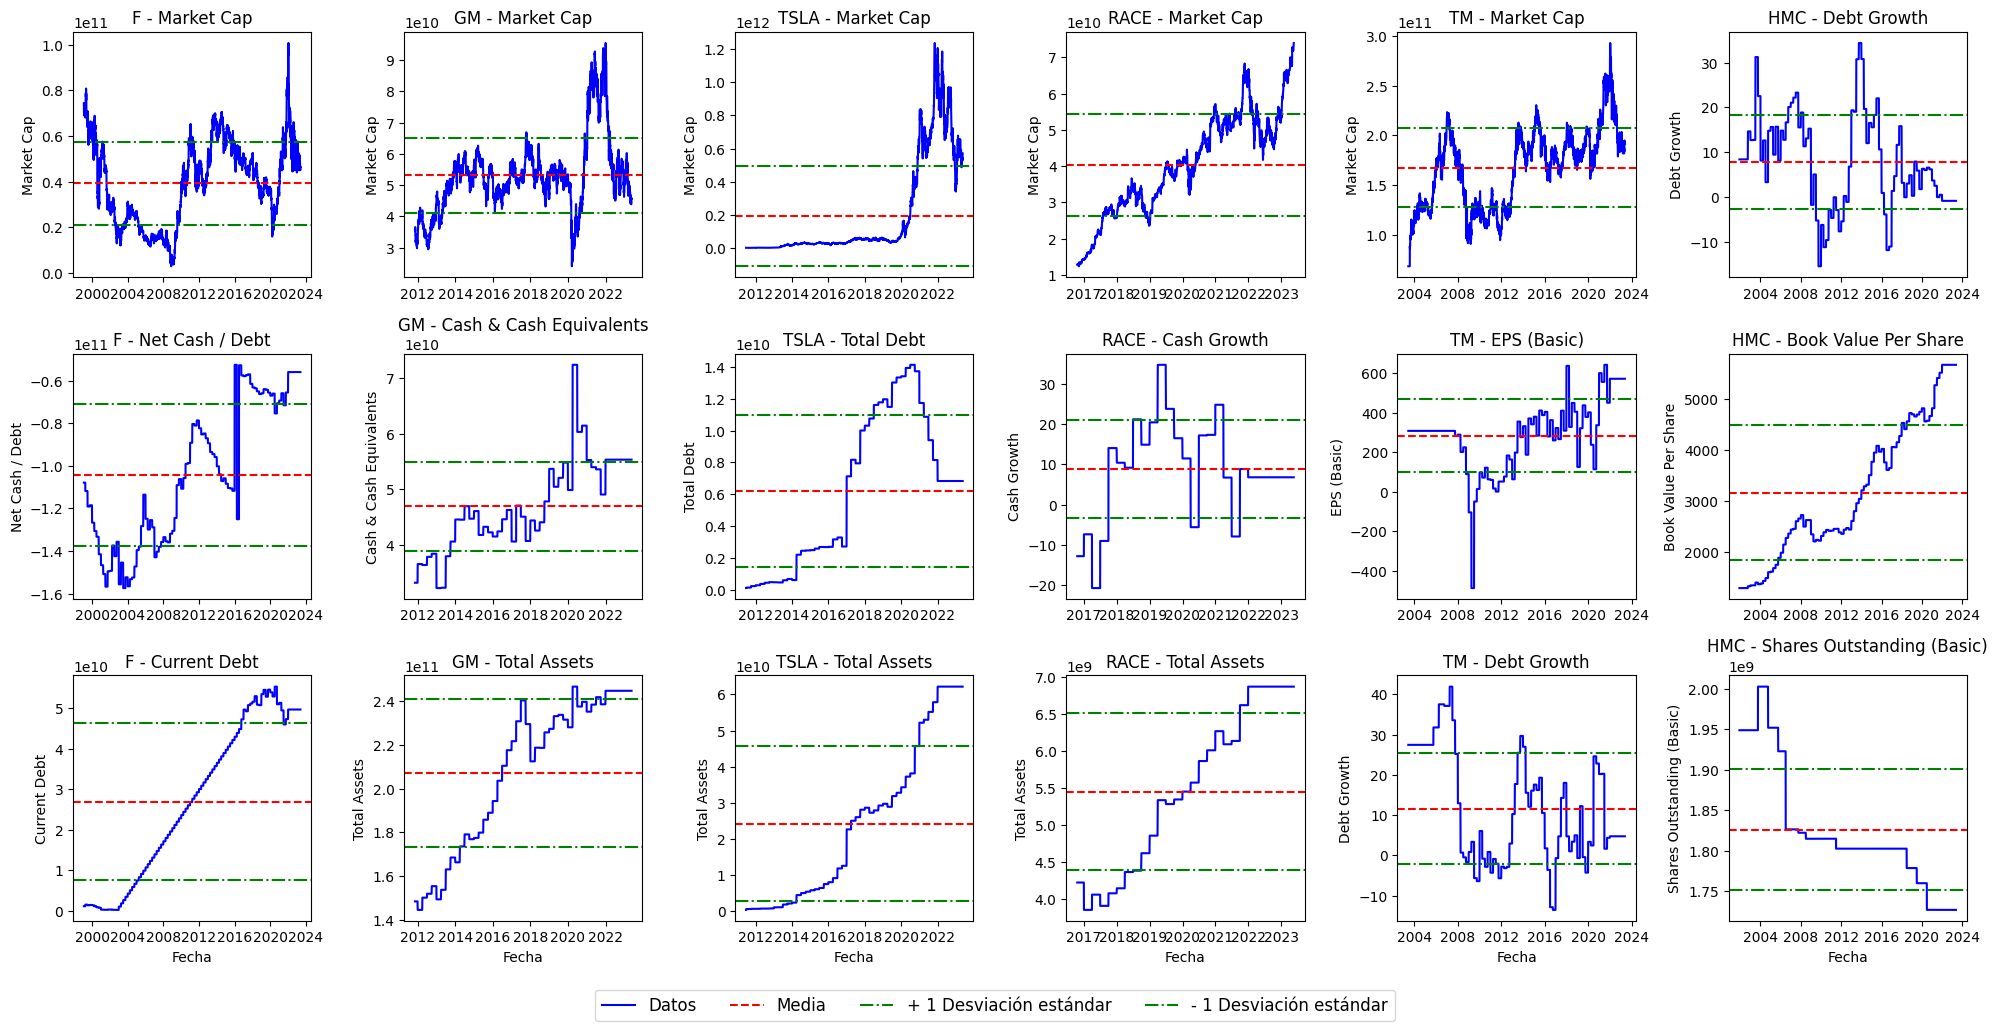

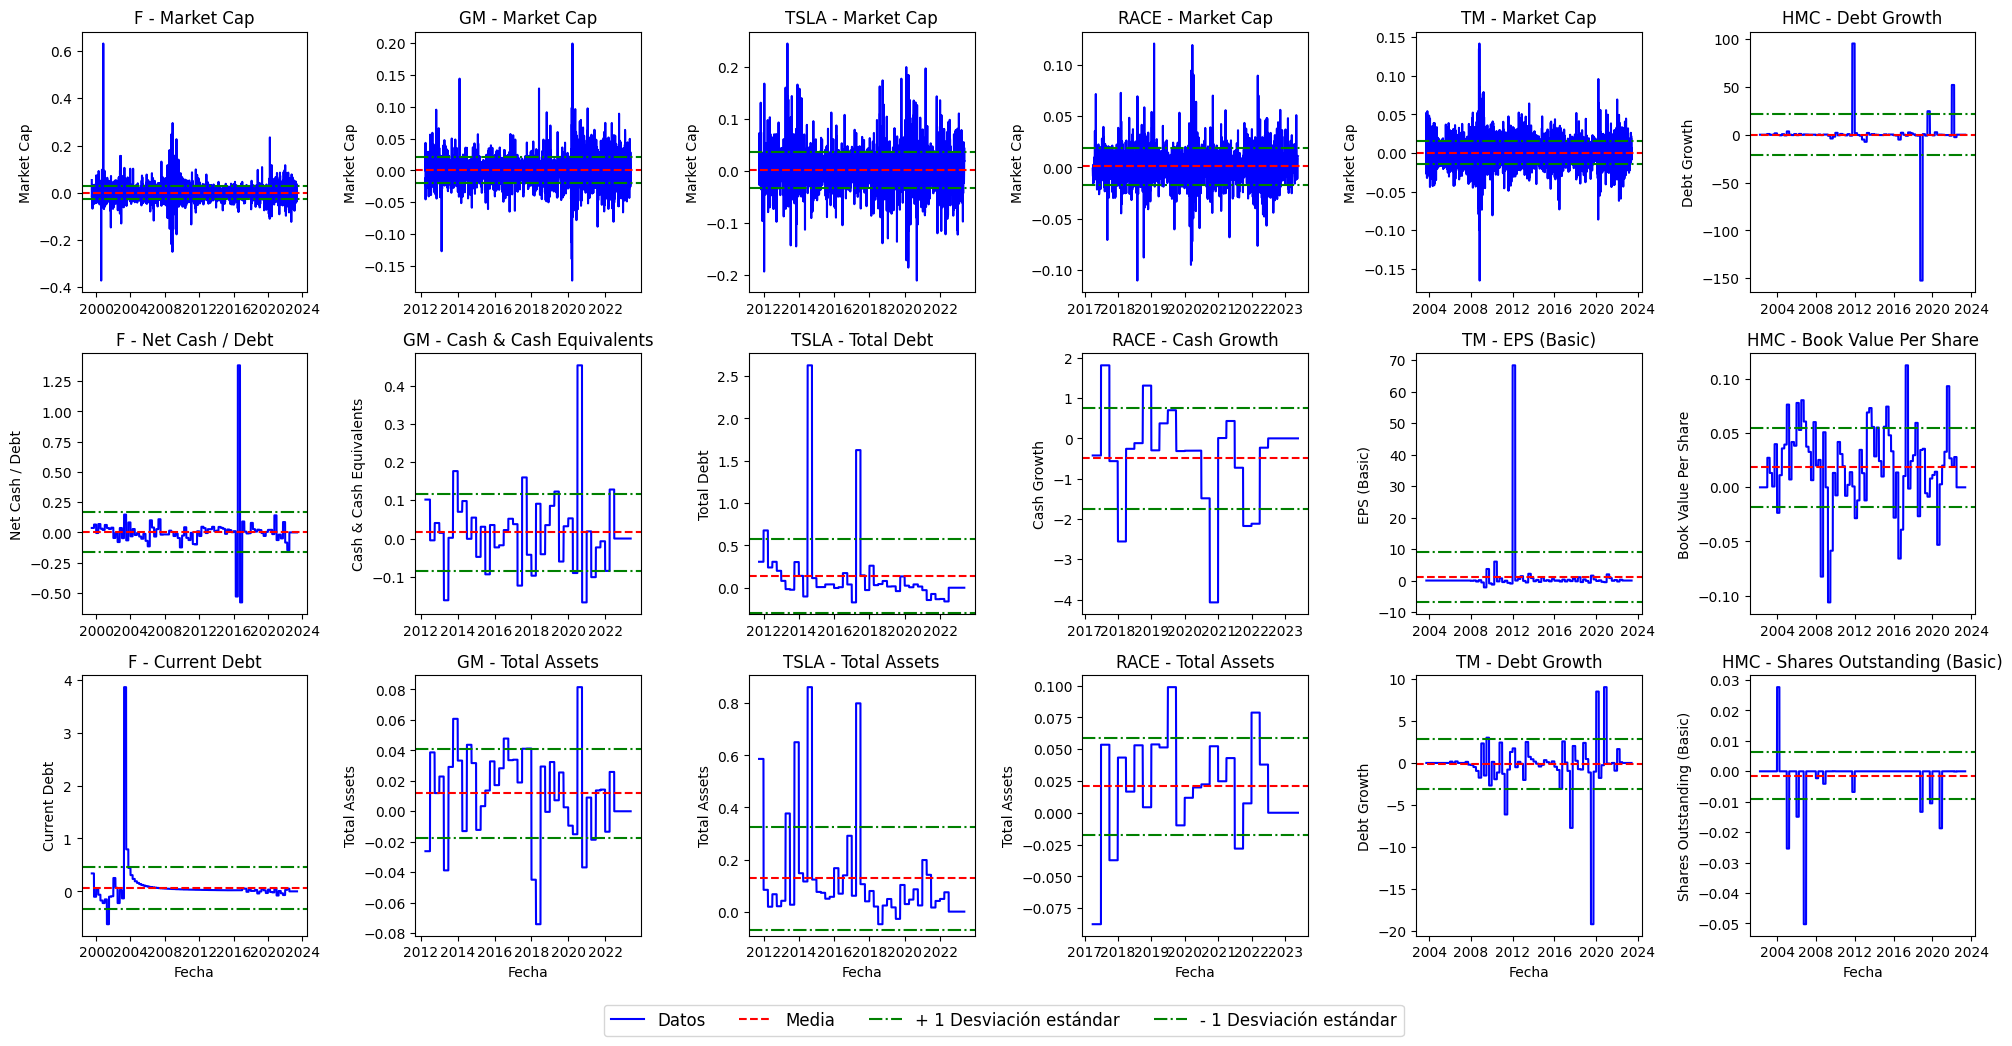

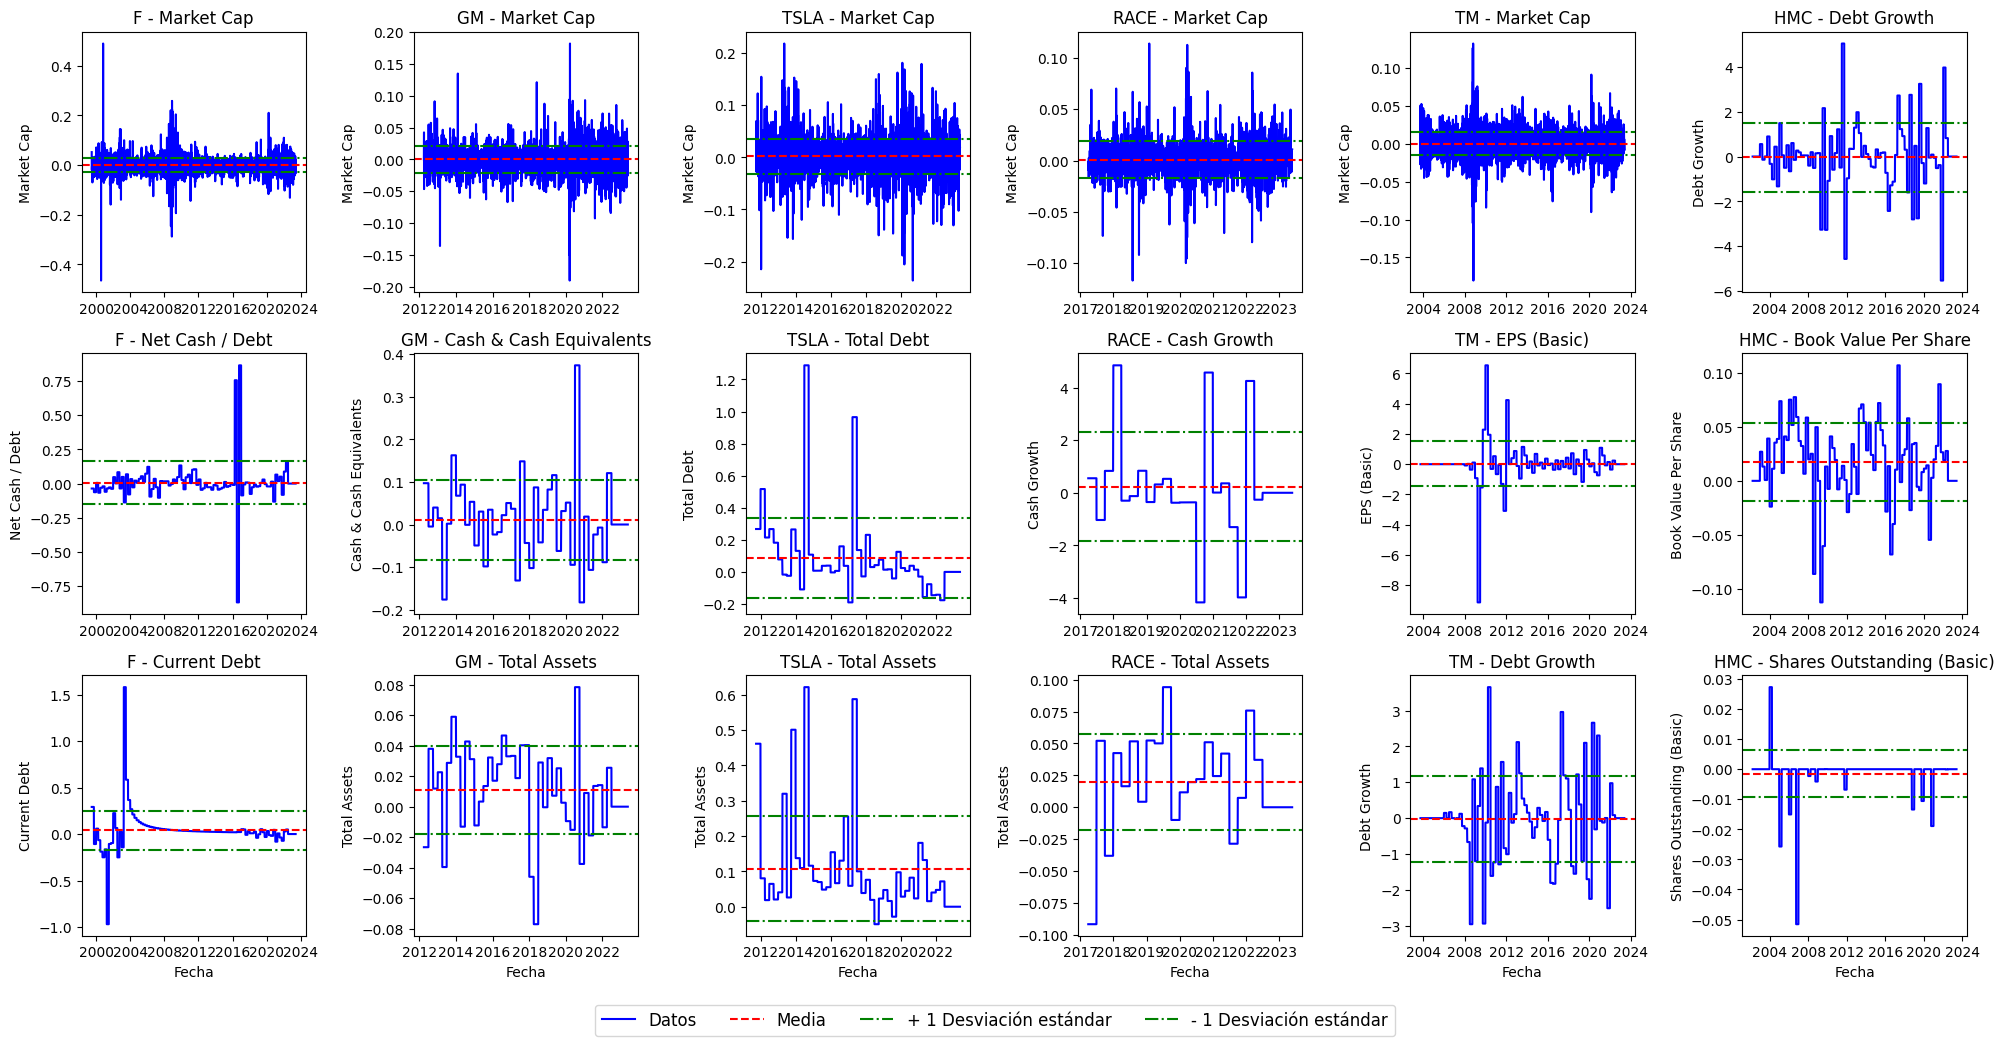

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

def plot_analysis(df,company, column, ax, row_idx, col_idx):
    mean = df[column].mean()
    std = df[column].std()

    sns.lineplot(data=df[column], color='blue', ax=ax)

    ax.axhline(mean, color='red', linestyle='--')
    ax.axhline(mean + std, color='green', linestyle='-.')
    ax.axhline(mean - std, color='green', linestyle='-.')

    #ax.legend(['Datos', 'Media', '+ 1 Desviación estándar', '- 1 Desviación estándar'])

    ax.set_xlabel('Fecha')
    ax.set_ylabel(column)
    ax.set_title(f'{company} - {column}')

    # Solo añadir etiqueta del eje x en la última fila
    if row_idx == 2:
        ax.set_xlabel('Fecha')
    else:
        ax.set_xlabel('')

# Diccionarios
company_var_dict = { 'F' : ['Market Cap', 'Net Cash / Debt','Current Debt'],
                    'GM' : ['Market Cap', 'Cash & Cash Equivalents', 'Total Assets' ],
                    'TSLA' : ['Market Cap', 'Total Debt', 'Total Assets'],
                    'RACE' : ['Market Cap', 'Cash Growth', 'Total Assets'],
                    'TM' : ['Market Cap', 'EPS (Basic)', 'Debt Growth'],
                    'HMC' : ['Debt Growth', 'Book Value Per Share', 'Shares Outstanding (Basic)']} 


for k in range(3):
    if k == 0:
        df_dict = dataframes
    elif k==1:
        df_dict = stationary_dataframes
    else:
        df_dict = stationary_log_dataframes
   
    fig, axes = plt.subplots(3, 6, figsize=(20, 10))  # Ajusta el tamaño según necesidad

    for i, company in enumerate(brands):
        for j, variable in enumerate(company_var_dict[company]):
            plot_analysis(df_dict[company],company, variable, axes[j, i], j, i)
    # Crea las líneas para la leyenda
    data_line = mlines.Line2D([], [], color='blue', label='Datos')
    mean_line = mlines.Line2D([], [], color='red', linestyle='--', label='Media')
    std_plus_line = mlines.Line2D([], [], color='green', linestyle='-.', label='+ 1 Desviación estándar')
    std_minus_line = mlines.Line2D([], [], color='green', linestyle='-.', label='- 1 Desviación estándar')

    # Crea una leyenda global
    fig.legend(handles=[data_line, mean_line, std_plus_line, std_minus_line], loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.05), fontsize='large')

    plt.tight_layout()
    plt.show()


                Open     Close      High       Low    Volume       MA1  \
Date                                                                     
2011-09-30 -0.036152  0.011194 -0.036026 -0.002548  0.437285 -0.002973   
2011-10-03  0.006050 -0.027060  0.004822 -0.010217 -0.234189 -0.004770   
2011-10-04 -0.066146 -0.003161 -0.027594 -0.013548  0.173084 -0.003595   
2011-10-05  0.031552  0.072289  0.062307  0.018313  0.024327 -0.002405   
2011-10-06  0.055556  0.062685  0.068525  0.071291  0.438878 -0.000603   
...              ...       ...       ...       ...       ...       ...   
2023-05-15 -0.047793 -0.009704 -0.042959 -0.016026 -0.331056 -0.003507   
2023-05-16 -0.011959  0.001022 -0.001426 -0.001215 -0.069169 -0.003055   
2023-05-17  0.016662  0.044079  0.029389  0.017250  0.276581 -0.001555   
2023-05-18  0.034499  0.017428  0.014670  0.031492 -0.127144 -0.000573   
2023-05-19  0.016933  0.018373  0.027618  0.022383  0.243574  0.000815   

                 MA2  Cash & Equivale

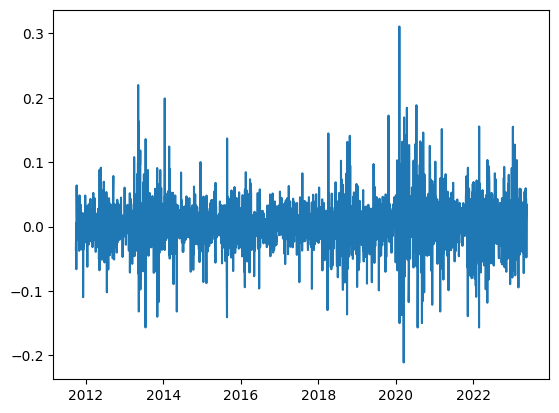

In [ ]:
print(stationary_dataframes['TSLA'])
Y = stationary_dataframes['TSLA'].Open
X = stationary_dataframes['TSLA'].index
plt.plot(X, Y)
plt.show()

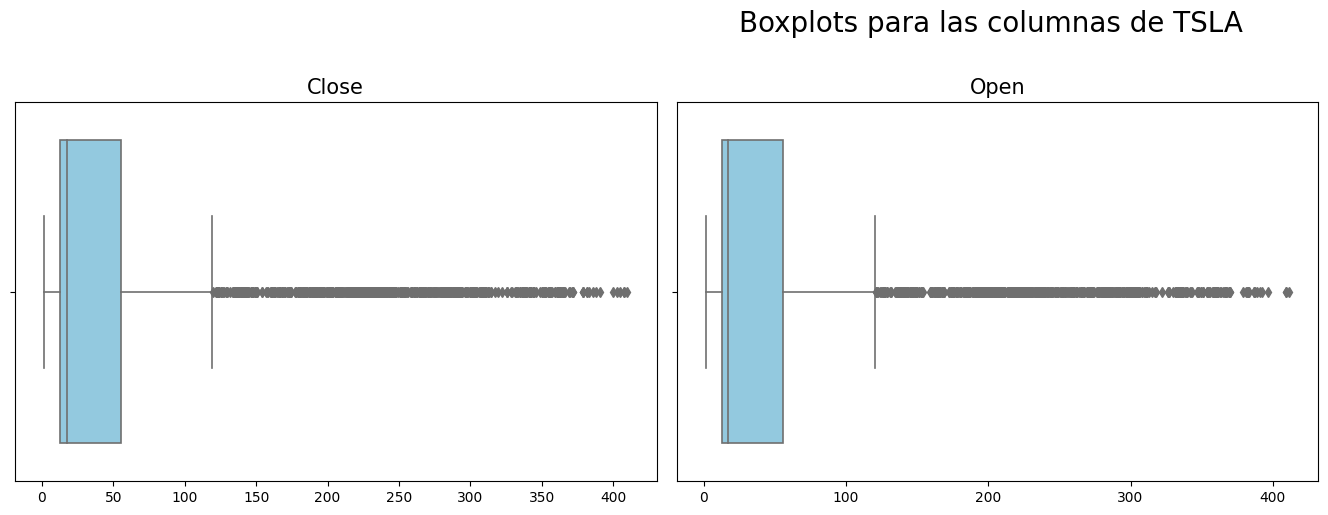

In [ ]:
import seaborn as sns

def plot_boxplots(df, variables, brand, plots_per_row=3):
    rows_needed = np.ceil(len(variables) / plots_per_row).astype(int)

    fig, ax = plt.subplots(nrows=rows_needed, ncols=plots_per_row, figsize=(20, rows_needed*5))

    # Añade un título a toda la figura
    fig.suptitle(f'Boxplots para las columnas de {brand} ', fontsize=20, y=1.02)

    # "ax" puede ser un array 2D si hay más de una fila. Para facilitar el indexado, lo aplanamos a 1D.
    ax = ax.ravel()

    # Usar seaborn para un boxplot más bonito
    for i, var in enumerate(variables):
        sns.boxplot(x=df[var], ax=ax[i], color='skyblue', fliersize=5, linewidth=1.2)
        ax[i].set_title(var, fontsize=15)
        ax[i].set_xlabel('')

    # Elimina los gráficos vacíos si no hay suficientes columnas para llenar la última fila
    for j in range(i+1, len(ax)):
        fig.delaxes(ax[j])

    plt.tight_layout()
    plt.show()

# Prueba la función con tu DataFrame 
plot_boxplots(dataframes['TSLA'], ['Close', 'Open'], 'TSLA')


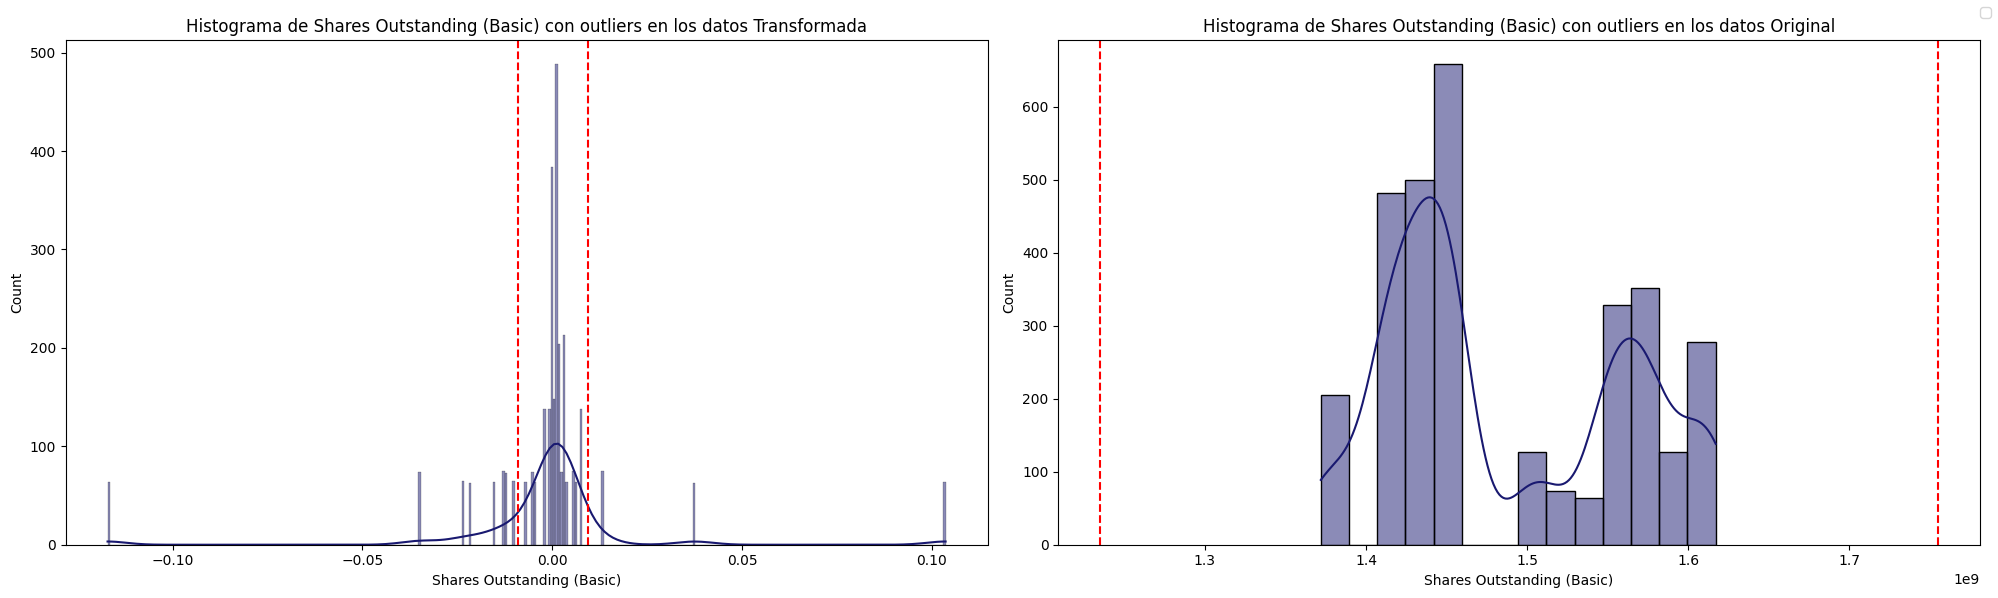

In [ ]:
def plot_histograms_with_outliers(df1, df2, variable):
    fig, axs = plt.subplots(1, 2, figsize=(20, 6))

    # Dibujar histogramas y líneas de outliers
    for ax, df, title in zip(axs, [df1, df2], ['Transformada', 'Original']):
        
        sns.histplot(data=df, x=variable, kde=True, color='midnightblue', ax=ax)

        # Calcular los cuartiles y el rango intercuartil
        Q1 = df[variable].quantile(0.25)
        Q3 = df[variable].quantile(0.75)
        IQR = Q3 - Q1

        # Definir los límites para los outliers
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR

        # Dibujar líneas verticales en los límites de los outliers
        ax.axvline(x=lower_limit, color='red', linestyle='--')
        ax.axvline(x=upper_limit, color='red', linestyle='--')

        ax.set_title(f'Histograma de {variable} con outliers en los datos {title}')

    # Crear una leyenda común para ambas subgráficas
    handles, labels = axs[0].get_legend_handles_labels()
    labels.extend(['Q1 - 1.5 * (Q3-Q1)', 'Q1 + 1.5 * (Q3-Q1)'])
    fig.legend(handles, labels, loc='upper right')

    plt.tight_layout()
    plt.show()


plot_histograms_with_outliers(stationary_dataframes['GM'], dataframes['GM'], variable)


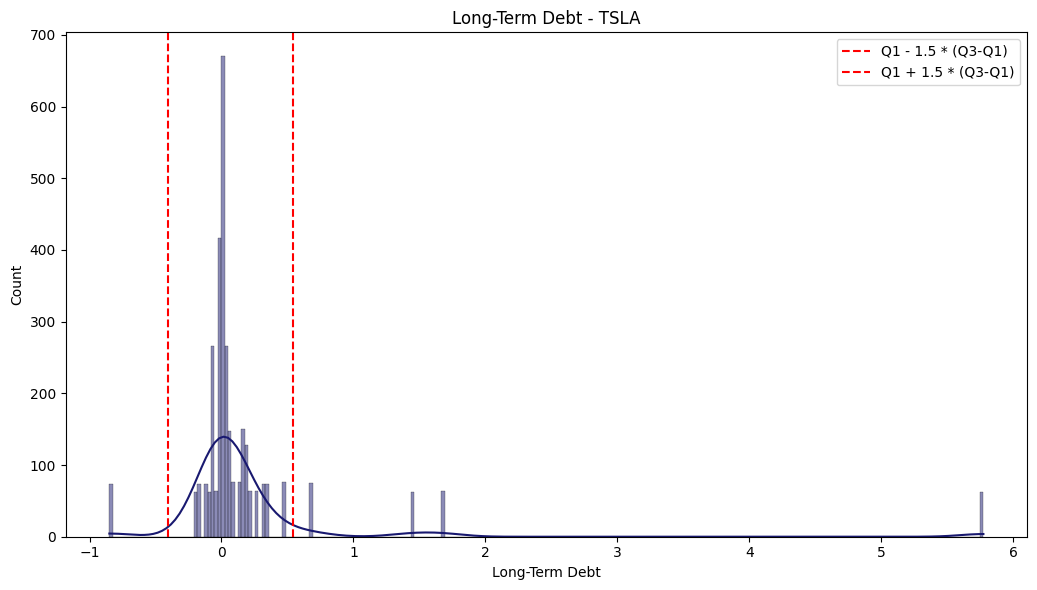

In [ ]:
def plot_histograms_with_outliers(df, variables):
    n = len(variables)
    columns = 3 # o el número que desees de columnas
    rows = (n + columns - 1) // columns
    plt.figure(figsize=(10*columns, 6*rows))
    for i, var in enumerate(variables, start=1):
        plt.subplot(rows, columns, i)
        sns.histplot(data=df, x=var, kde=True, color='midnightblue')
        
        # calcular los cuartiles y el rango intercuartil
        Q1 = df[var].quantile(0.25)
        Q3 = df[var].quantile(0.75)
        IQR = Q3 - Q1

        # Definir los límites para los outliers
        lower_limit = Q1 - 2 * IQR
        upper_limit = Q3 + 2 * IQR

        # dibujar líneas verticales en los límites de los outliers
        plt.axvline(x=lower_limit, color='red', linestyle='--', label = 'Q1 - 1.5 * (Q3-Q1)')
        plt.axvline(x=upper_limit, color='red', linestyle='--', label = 'Q1 + 1.5 * (Q3-Q1)')

        plt.title(f'{var} - TSLA')
        plt.legend()
    plt.tight_layout()
    plt.show()
v = ['Long-Term Debt']
plot_histograms_with_outliers(stationary_dataframes['TSLA'], v)


In [ ]:
for c in stationary_dataframes['TSLA'].columns: 
    print(c)
    

Open
Close
High
Low
Volume
MA1
MA2
Cash & Equivalents
Cash & Cash Equivalents
Cash Growth
Receivables
Inventory
Other Current Assets
Total Current Assets
Property, Plant & Equipment
Other Long-Term Assets
Total Long-Term Assets
Total Assets
Accounts Payable
Deferred Revenue
Current Debt
Total Current Liabilities
Other Current Liabilities
Long-Term Debt
Total Long-Term Liabilities
Other Long-Term Liabilities
Total Liabilities
Total Debt
Debt Growth
Common Stock
Retained Earnings
Shareholders' Equity
Net Cash / Debt
Net Cash / Debt Growth
Net Cash Per Share
Working Capital
Book Value Per Share
Net Income_x
Depreciation & Amortization_x
Share-Based Compensation
Other Operating Activities
Operating Cash Flow
Operating Cash Flow Growth
Capital Expenditures
Other Investing Activities
Investing Cash Flow
Share Issuance / Repurchase
Debt Issued / Paid
Other Financing Activities
Financing Cash Flow
Net Cash Flow
Free Cash Flow
Free Cash Flow Growth
Free Cash Flow Margin_x
Revenue
Revenue Growth

<Axes: xlabel='Date'>

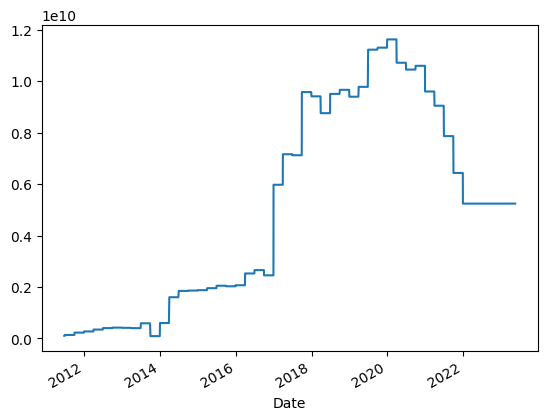

In [ ]:
dataframes['TSLA']['Long-Term Debt'].plot()

In [ ]:
from scipy import stats
for brand in brands: 
   # 1. Calcula el z-score de cada elemento en cada columna
   z_scores = stationary_dataframes[brand][daily_variables].apply(stats.zscore)

   # 2. Determina el número de outliers en cada columna (un z-score absoluto de > 3 suele ser un indicador de outlier)
   outliers = z_scores > 3

   # 3. Ordena las columnas por el número de outliers
   outliers_count = outliers.sum().sort_values(ascending=False)

   # 4. Selecciona las primeras 10 columnas
   top_10_columns_with_outliers = outliers_count.head(10)
   #plot_boxplots(stationary_dataframes[brand], top_10_columns_with_outliers[:4].index, brand, plots_per_row=4)
   print(brand, ' :\n',top_10_columns_with_outliers)

F  :
 MA2           88
RSI           83
HBOLLINGER    64
EMA14         62
Market Cap    59
Close         55
Open          55
High          54
ADX           52
MA1           49
dtype: int64
GM  :
 MA2           53
RSI           36
High          28
HBOLLINGER    28
Close         25
Market Cap    25
Open          23
LBOLLINGER    19
EMA14         19
Low           19
dtype: int64
TSLA  :
 Volume        51
HBOLLINGER    45
MA1           40
LBOLLINGER    39
EMA50         39
RSI           38
High          37
Market Cap    37
Close         36
Low           33
dtype: int64
RACE  :
 Volume        28
Open          19
HBOLLINGER    18
RSI           18
Market Cap    17
Close         17
Low           16
High          15
CMF           15
LBOLLINGER    13
dtype: int64
TM  :
 Volume        80
RSI           70
High          44
LBOLLINGER    43
Market Cap    42
Close         42
Open          41
HBOLLINGER    40
ADX           36
Low           33
dtype: int64
HMC  :
 Volume        79
RSI           69
Open 

In [58]:

stationary_dataframes['F'] = stationary_dataframes['F'].drop(['Operating Cash Flow Growth','Other Expense / Income','Market Cap Growth', 'Debt Growth'] , axis = 1)
stationary_dataframes['GM'] = stationary_dataframes['GM'].drop(['Goodwill and Intangibles','Short-Term Investments','Working Capital','Other Financing Activities','Free Cash Flow Growth'] , axis = 1)
stationary_dataframes['TSLA'] = stationary_dataframes['TSLA'].drop(['Market Cap Growth', 'Share Issuance / Repurchase','Net Cash Flow','Effective Tax Rate'] , axis = 1)
stationary_dataframes['RACE'] = stationary_dataframes['RACE'].drop(['Profit Margin', 'Debt Growth', 'Other Current Assets','Pretax Income','Interest Expense / Income'] , axis = 1)
stationary_dataframes['TM'] = stationary_dataframes['TM'].drop(['Profit Margin','Other Current Assets','Other Expense / Income','Free Cash Flow Growth'] , axis = 1)
stationary_dataframes['HMC'] = stationary_dataframes['HMC'].drop(['Free Cash Flow Growth','Operating Cash Flow Growth','Interest Expense / Income'] , axis = 1)
from scipy import stats



In [59]:
df = stationary_dataframes['TSLA'].copy()
print(df.shape)
print(df[daily_variables].isnull().values)
df = df.dropna()
nan_locs = np.where(df.isna())

# Esto devuelve una tupla de arrays, donde el primer array contiene las filas y el segundo las columnas
# donde se encontraron los NaNs.

for row, col in zip(*nan_locs):
    print(f"NaN encontrado en la fila {row}, columna {col} ({df.columns[col]}).")

(3224, 101)
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


In [60]:
for brand in brands:
    print(brand)
    input_df = stationary_dataframes[brand].copy()
    print("Shape antes de eliminar outliers:", input_df.shape)

    # Comprueba si hay NaNs en tus datos
    if input_df[daily_variables].isnull().values.any():
        print("Hay valores NaN en los datos de entrada. Considera rellenarlos o eliminarlos antes de calcular el z-score.")

    # Comprueba si hay columnas con desviación estándar cero
    if (input_df[daily_variables].std() == 0).any():
        print("Hay columnas con desviación estándar cero en los datos de entrada. Considera eliminar estas columnas o verificar los datos.")

    # Comprueba si hay columnas no numéricas
    if (input_df[daily_variables].dtypes == 'object').any():
        print("Hay columnas no numéricas en los datos de entrada. Considera convertirlas a un tipo numérico antes de calcular el z-score.")


F
Shape antes de eliminar outliers: (6602, 98)
GM
Shape antes de eliminar outliers: (3076, 101)
TSLA
Shape antes de eliminar outliers: (3224, 101)
RACE
Shape antes de eliminar outliers: (1693, 91)
TM
Shape antes de eliminar outliers: (5431, 98)
HMC
Shape antes de eliminar outliers: (5839, 100)


In [ ]:
stationary_dataframes['F']['SO'].isnull().values

{False}

In [ ]:
mask

Date
2002-03-31    False
2002-04-01    False
2002-04-02    False
2002-04-03    False
2002-04-04    False
              ...  
2023-05-16    False
2023-05-17    False
2023-05-18    False
2023-05-19    False
2023-05-22    False
Length: 5837, dtype: bool

In [61]:
daily_variables2 = daily_variables.copy()
daily_variables2.remove('SO')
for brand in brands:
   print(brand)
   input_df = stationary_dataframes[brand].copy()
   print(input_df.shape)

   # Seleccionamos solo las columnas que están en daily_variables
   selected_df = input_df[daily_variables2].copy()

   # Aplicamos zscore solo a las columnas seleccionadas
   mask = (np.abs(stats.zscore(selected_df)) < 4).all(axis=1)

   # Filtramos las filas usando la máscara
   input_df = input_df[mask]
   
   print(input_df.shape)
   stationary_dataframes[brand] = input_df


F
(6602, 98)
(6323, 98)
GM
(3076, 101)
(2976, 101)
TSLA
(3224, 101)
(3076, 101)
RACE
(1693, 91)
(1611, 91)
TM
(5431, 98)
(5211, 98)
HMC
(5839, 100)
(5627, 100)


In [ ]:
def plot_histograms(df):
    # Número de columnas numéricas
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns

    # Tamaño del gráfico
    fig, axs = plt.subplots(len(num_cols), figsize=(10, 5 * len(num_cols)))

    # Loop a través de cada columna
    for i, col in enumerate(num_cols):
        # Graficar histograma de la columna
        axs[i].hist(df[col].dropna(), bins=30)
        axs[i].set_title(f'Histograma de {col}')

    # Asegúrate de que la visualización se muestra correctamente
    plt.tight_layout()
    plt.show()


In [62]:
for brand in brands:
    stationary_dataframes[brand] = stationary_dataframes[brand].iloc[1:]
    stationary_dataframes[brand].to_excel(f'Estacionaridad/{brand}_stationary.xlsx', 'w')
    stationary_dataframes[brand].to_csv(f'Estacionaridad/{brand}_stationary.csv', mode = 'w')


# LAGS IMPLEMENTATION

Study of the Lags used as prediction

Reducimos la cantidad de lags máximo que se pueden utilizar por facilidad computacional

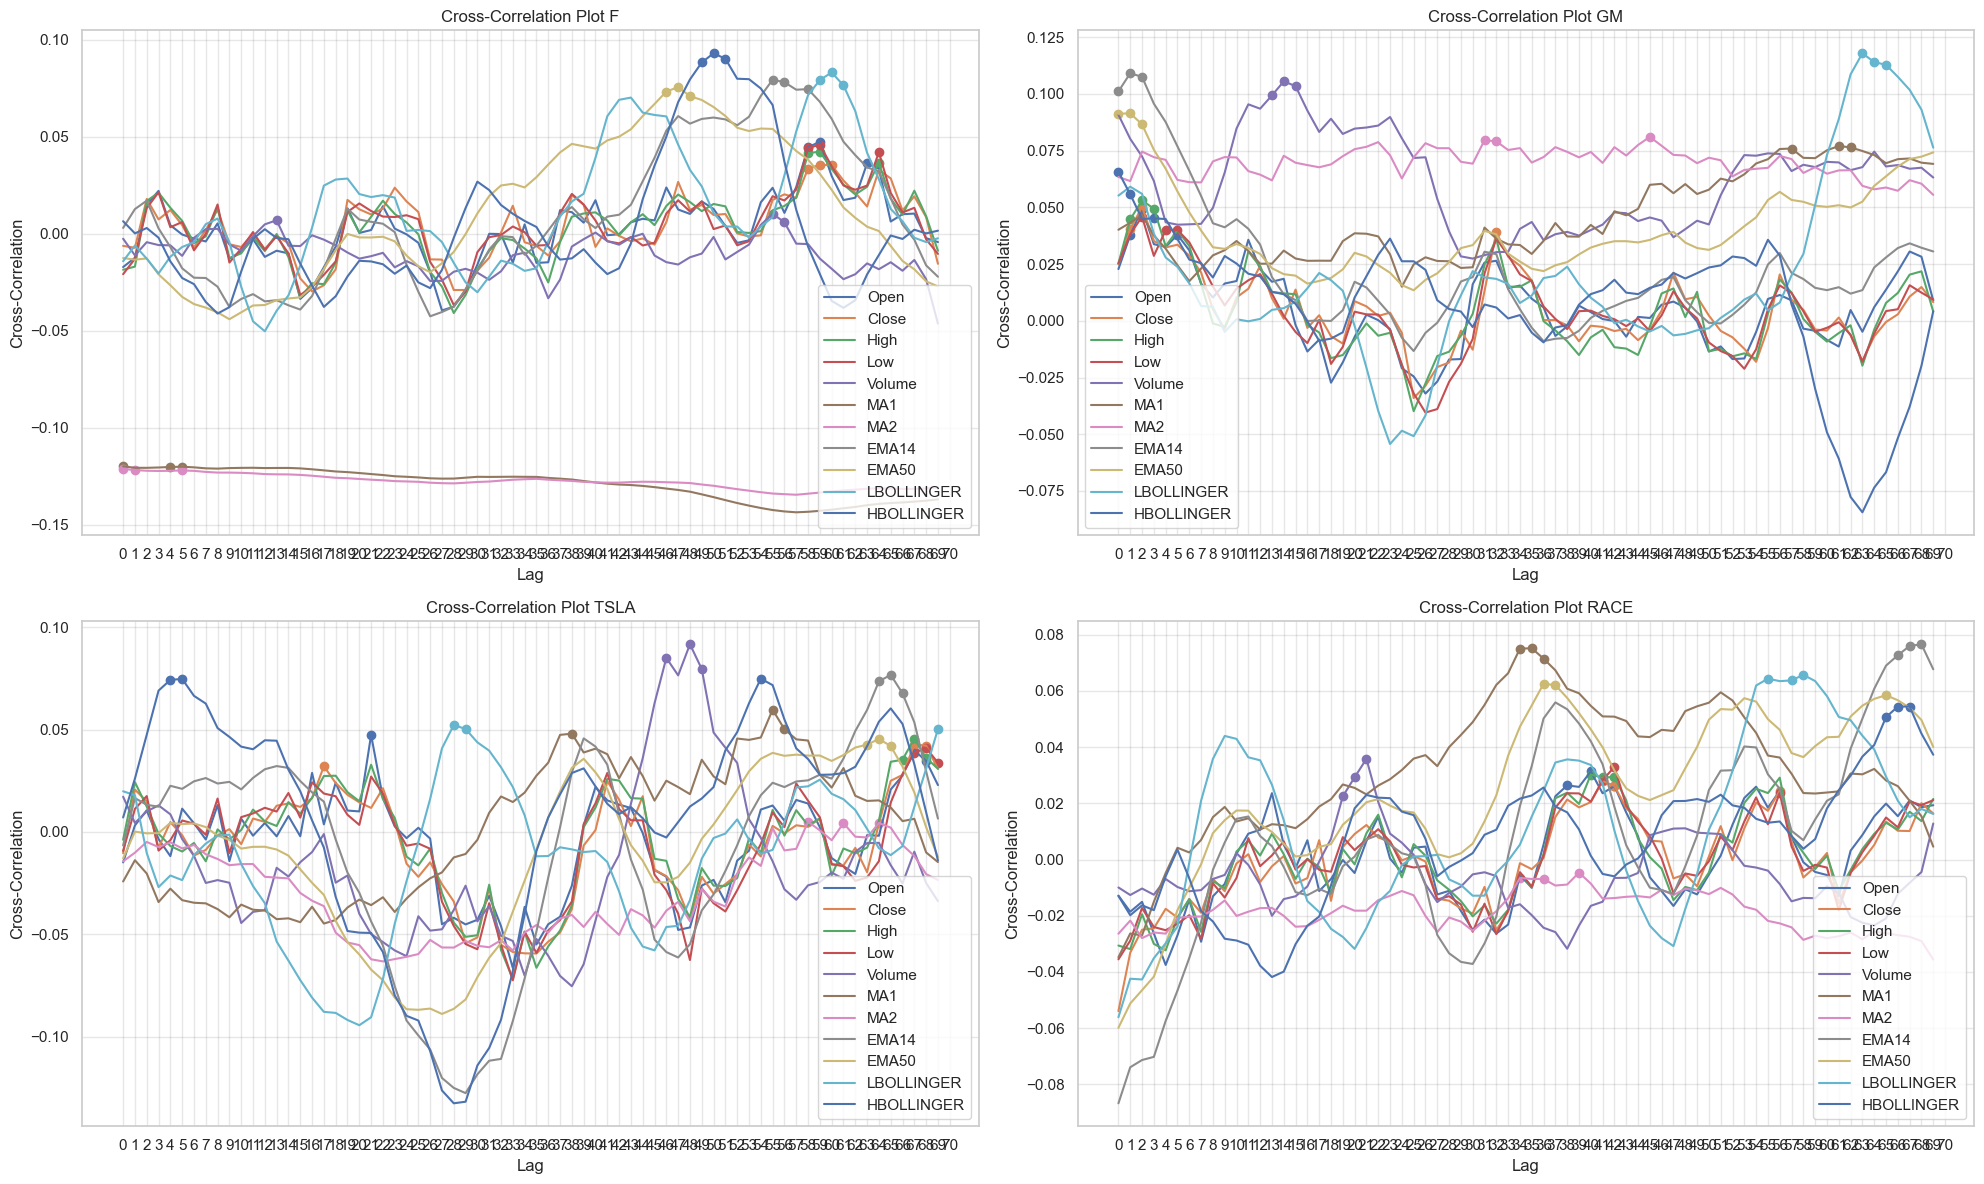

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import ccf

y = input_df['Target']
 # Tus cuatro DataFrames
variables = ['Open', 'Close', 'High', 'Low', 'Volume', 'MA1', 'MA2', 'EMA14', 'EMA50', 'LBOLLINGER', 'HBOLLINGER']

fig, axs = plt.subplots(2, 2, figsize=(20, 12))  # Crea una figura con 4 subplots (2 filas, 2 columnas)
i = 0
dfs = list(stationary_dataframes.values())
for ax, input_df in zip(axs.flatten(), dfs[1:5]):
    y = input_df['Target']
    for header in variables:
        x = input_df[header]
        cross_correlation = ccf(y, x, unbiased=True)[:70]
        max_lags = np.argsort(-cross_correlation)[:3]  # toma los primeros tres después de ordenar en orden descendente
        ax.plot(cross_correlation, label=header)
        ax.scatter(max_lags, cross_correlation[max_lags])
    
    ax.set_title(f'Cross-Correlation Plot {brands[i]}')
    ax.set_xlabel('Lag')
    ax.set_ylabel('Cross-Correlation')
    ax.set_xticks(range(0, 71))
    ax.legend()
    ax.grid(True)
    i +=1

plt.tight_layout()
plt.show()



TRANSFORMAR LOS DATOS PARA MANTENER LOS PERIODOS

Para las trimestrales hay que coger el valor de los otros trimestres.


In [2]:

import math # Mathematical functions
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # Additional functions for analysing and manipulating data
from datetime import date # Date Functions
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import matplotlib.dates as mdates # Formatting dates
from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
import tensorflow as tf
from tensorflow.keras.models import Sequential # Deep learning library, used for neural networks
from tensorflow.keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training
from sklearn.preprocessing import RobustScaler, MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data
#from keras.optimizers import Adam # For detailed configuration of the optimizer
import seaborn as sns # Visualization
plt.rcParams["grid.color"] = "k"  # Esto pone una cuadrícula con líneas de color negro
plt.rcParams["grid.alpha"] = 0.1  # Esto hace que las líneas de la cuadrícula sean muy transparentes


from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler


In [1]:
daily_variables = ['Open', 'Close', 'High', 'Low', 'Volume', 'MA1', 'MA2', 'Market Cap']
indicators = ['RSI', 'EMA14', 'EMA50', 'MACD', 'ADX', 'CMF', 'SO', 'LBOLLINGER', 'HBOLLINGER', 'FI']
daily_variables.extend(indicators)

dataframes = {}
lagged_dataframes = {}
stationary_dataframes = {}
lagged_stationary_dataframes = {}
brands = ['F', 'GM', 'TSLA', 'RACE', 'TM', 'HMC' ]

In [3]:
def set_index(df):
   df = df.set_index('Date')
   df.index.name = 'Date'
   df.index = pd.to_datetime(df.index)
   return df

In [4]:
for brand in brands:
   df = pd.read_csv(f'Estacionaridad/{brand}_stationary.csv')
   stationary_dataframes[brand] = set_index(df)

In [11]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits = 3, gap=7)
df = stationary_dataframes['F']

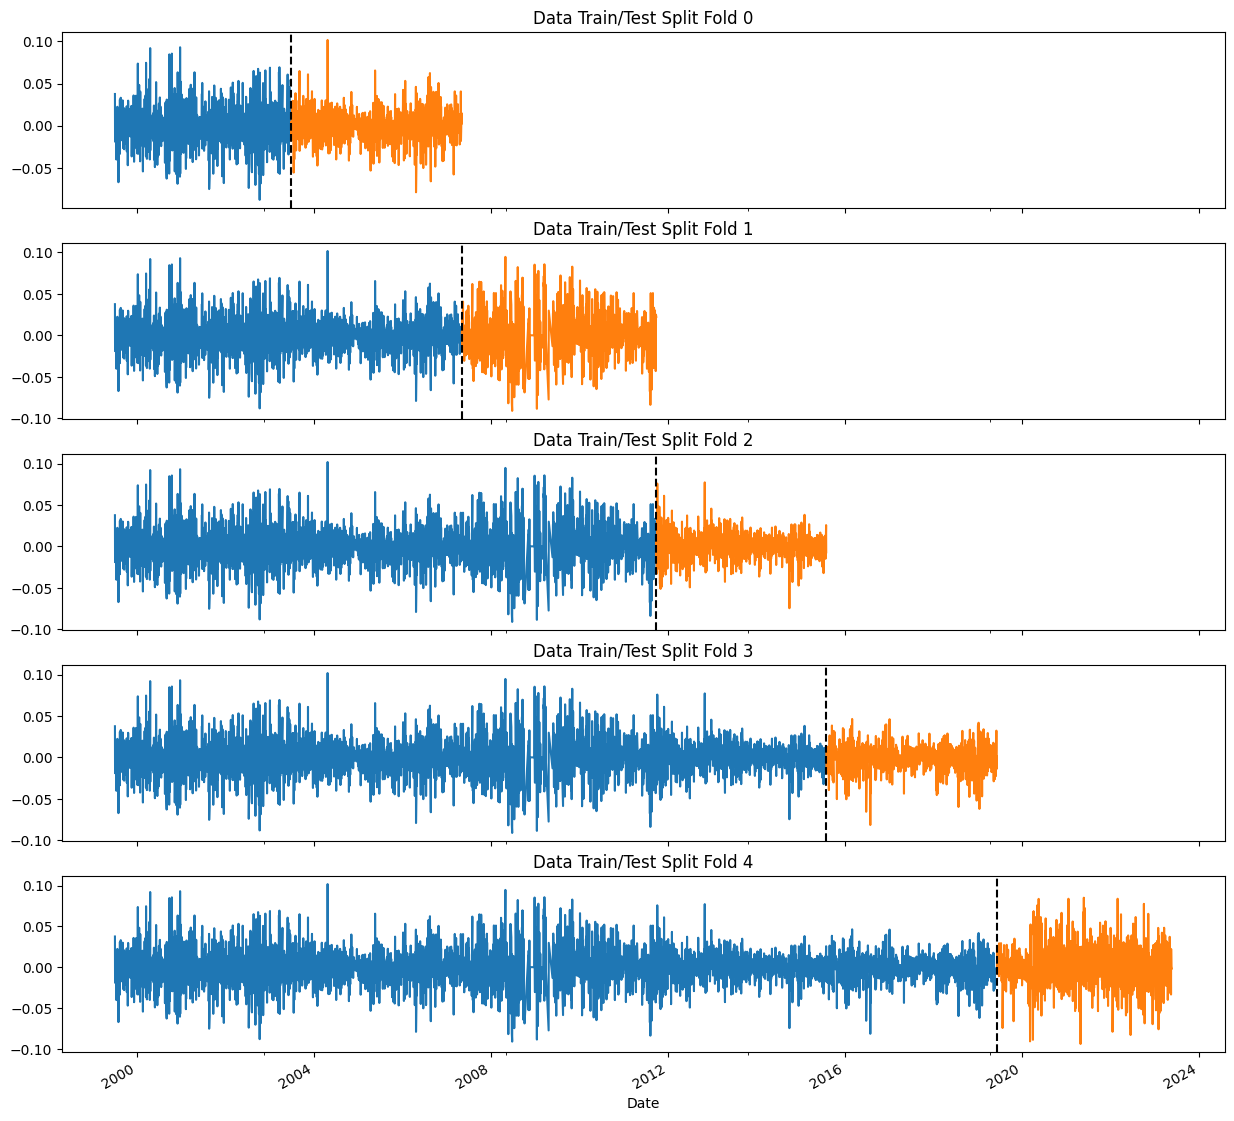

In [9]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['Close'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['Close'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

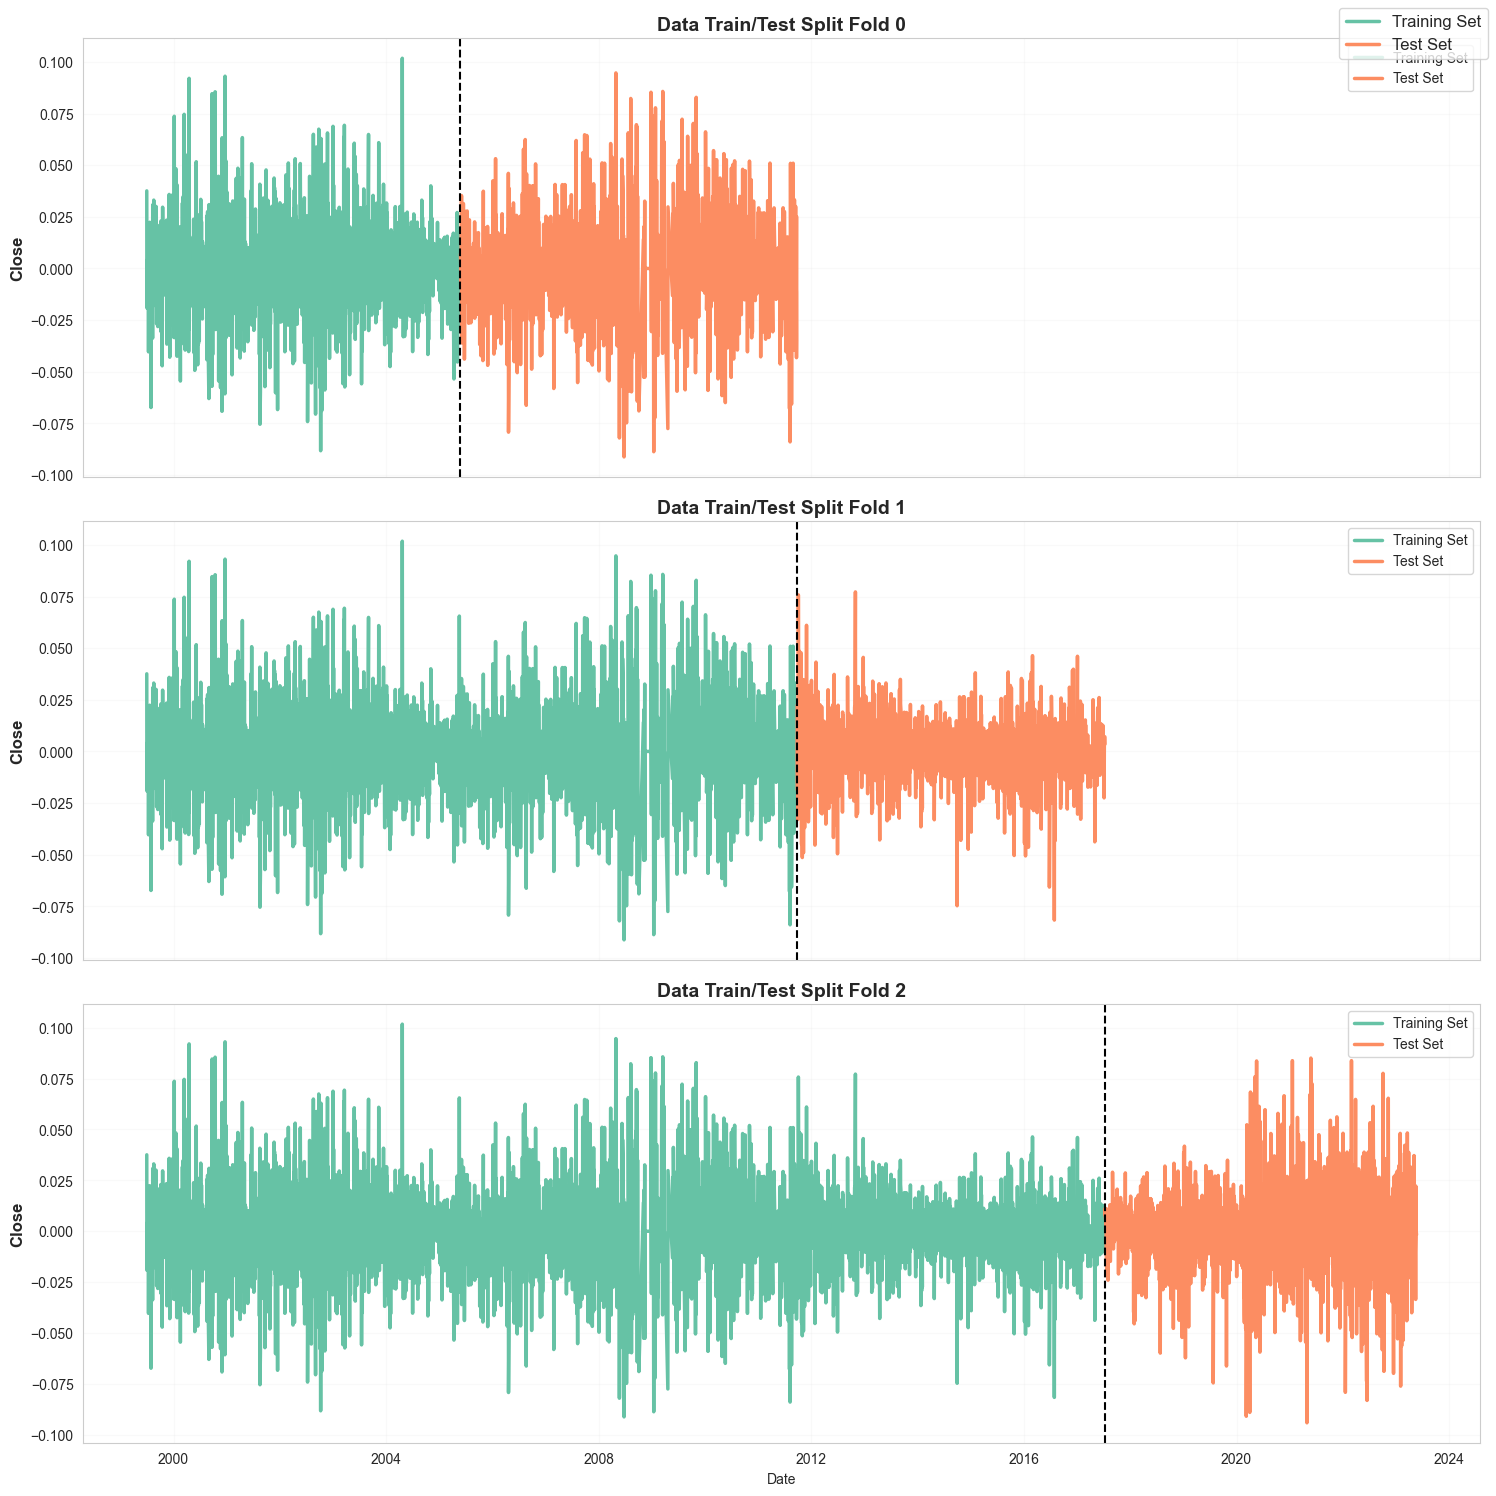

In [12]:
import seaborn as sns

# Definir el estilo y la paleta de colores de Seaborn
sns.set_style("whitegrid")
sns.set_palette("Set2")

fig, axs = plt.subplots(3, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    # Usar la función sns.lineplot para dibujar las gráficas
    sns.lineplot(data=train, x=train.index, y='Close', ax=axs[fold], label='Training Set', linewidth=2.5)
    sns.lineplot(data=test, x=test.index, y='Close', ax=axs[fold], label='Test Set', linewidth=2.5)
    
    # Añadir una línea vertical en el punto de inicio del conjunto de prueba
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    
    # Ajustar títulos y etiquetas
    axs[fold].set_title(f'Data Train/Test Split Fold {fold}', fontsize=14, fontweight='bold')
    axs[fold].set_ylabel('Close', fontsize=12, fontweight='bold')
    if fold == 4: # Último sub-gráfico
        axs[fold].set_xlabel('Date', fontsize=12, fontweight='bold')
    fold += 1

# Ajustar el espacio entre los sub-gráficos y mostrar la leyenda
plt.tight_layout()
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', fontsize='large')
plt.show()


In [9]:
def get_quarter_lagged(series, n_quarters=1):
    # Cambiar a la frecuencia trimestral y obtener el primer valor de cada trimestre
    s_quarterly = series.resample('Q').first()
    
    # Obtener el valor de lag para n_quarters
    s_quarterly_lagged = s_quarterly.shift(n_quarters)
    
    # Regresar a la frecuencia diaria
    s_lagged = s_quarterly_lagged.resample('D').pad()
    
    # Volver a alinear con el índice original
    s_lagged = s_lagged.reindex(series.index)
    
    return s_lagged

In [10]:
dataframes_lagged_stationary = {}

for brand in brands:
    input_df = stationary_dataframes[brand].copy()
    df_lagged = input_df.copy()

    print(brand, input_df.shape)


    # Lags for 'daily_variables'
    daily_lags = range(1, 21)  # lags from 1 to 14
    for col in daily_variables:
        df_lag = pd.DataFrame({f'{col}_lag{lag}': input_df[col].shift(lag) for lag in daily_lags})
        df_lagged = pd.concat([df_lagged, df_lag], axis=1)

    # Lags for 'Target'
    target_lags = range(7, 18)  # lags from 7 to 10
    df_lag = pd.DataFrame({f'Target_lag{lag}': input_df['Target'].shift(lag) for lag in target_lags})
    df_lagged = pd.concat([df_lagged, df_lag], axis=1)

    # Lags para el resto de las variables (exceptuando 'Target', 'Nominal_Close', 'Nominal_Target' y las 'daily_variables')
    quarterly_variables = [col for col in input_df.columns if col not in ['Target', 'Nominal_Close', 'Nominal_Target'] + daily_variables]
    lagged_dataframes = []
    for col in quarterly_variables:
        for lag in range(1,6):  # cinco lags, correspondientes a los dos trimestres anteriores
            col_lagged = get_quarter_lagged(input_df[col], lag)
            lagged_dataframes.append(col_lagged.to_frame(f'{col}_lag{lag}'))

    # Concatena todas las columnas lagged a tu DataFrame original
    df_lagged = pd.concat([df_lagged] + lagged_dataframes, axis=1)

    # Elimina las filas con NaNs que se hayan podido crear al obtener los lags
    df_lagged = df_lagged.dropna()
    dataframes_lagged_stationary[brand] = df_lagged
    print(df_lagged.shape)
 #   df_lagged.to_excel(f'Lags/Stationary/{brand}_lagged_stationary.xlsx', 'w')
#    df_lagged.to_csv(f'Lags/Stationary/{brand}_lagged_stationary.csv', mode = 'w')


F (6322, 98)


C:\Users\pablo\AppData\Local\Temp\ipykernel_21156\844575292.py:9: FutureWarning: pad is deprecated and will be removed in a future version. Use ffill instead.
  s_lagged = s_quarterly_lagged.resample('D').pad()
C:\Users\pablo\AppData\Local\Temp\ipykernel_21156\844575292.py:9: FutureWarning: pad is deprecated and will be removed in a future version. Use ffill instead.
  s_lagged = s_quarterly_lagged.resample('D').pad()
C:\Users\pablo\AppData\Local\Temp\ipykernel_21156\844575292.py:9: FutureWarning: pad is deprecated and will be removed in a future version. Use ffill instead.
  s_lagged = s_quarterly_lagged.resample('D').pad()
C:\Users\pablo\AppData\Local\Temp\ipykernel_21156\844575292.py:9: FutureWarning: pad is deprecated and will be removed in a future version. Use ffill instead.
  s_lagged = s_quarterly_lagged.resample('D').pad()
C:\Users\pablo\AppData\Local\Temp\ipykernel_21156\844575292.py:9: FutureWarning: pad is deprecated and will be removed in a future version. Use ffill instea

(5930, 859)
GM (2975, 101)


C:\Users\pablo\AppData\Local\Temp\ipykernel_21156\844575292.py:9: FutureWarning: pad is deprecated and will be removed in a future version. Use ffill instead.
  s_lagged = s_quarterly_lagged.resample('D').pad()
C:\Users\pablo\AppData\Local\Temp\ipykernel_21156\844575292.py:9: FutureWarning: pad is deprecated and will be removed in a future version. Use ffill instead.
  s_lagged = s_quarterly_lagged.resample('D').pad()
C:\Users\pablo\AppData\Local\Temp\ipykernel_21156\844575292.py:9: FutureWarning: pad is deprecated and will be removed in a future version. Use ffill instead.
  s_lagged = s_quarterly_lagged.resample('D').pad()
C:\Users\pablo\AppData\Local\Temp\ipykernel_21156\844575292.py:9: FutureWarning: pad is deprecated and will be removed in a future version. Use ffill instead.
  s_lagged = s_quarterly_lagged.resample('D').pad()
C:\Users\pablo\AppData\Local\Temp\ipykernel_21156\844575292.py:9: FutureWarning: pad is deprecated and will be removed in a future version. Use ffill instea

(2583, 877)
TSLA (3075, 101)


C:\Users\pablo\AppData\Local\Temp\ipykernel_21156\844575292.py:9: FutureWarning: pad is deprecated and will be removed in a future version. Use ffill instead.
  s_lagged = s_quarterly_lagged.resample('D').pad()
C:\Users\pablo\AppData\Local\Temp\ipykernel_21156\844575292.py:9: FutureWarning: pad is deprecated and will be removed in a future version. Use ffill instead.
  s_lagged = s_quarterly_lagged.resample('D').pad()
C:\Users\pablo\AppData\Local\Temp\ipykernel_21156\844575292.py:9: FutureWarning: pad is deprecated and will be removed in a future version. Use ffill instead.
  s_lagged = s_quarterly_lagged.resample('D').pad()
C:\Users\pablo\AppData\Local\Temp\ipykernel_21156\844575292.py:9: FutureWarning: pad is deprecated and will be removed in a future version. Use ffill instead.
  s_lagged = s_quarterly_lagged.resample('D').pad()
C:\Users\pablo\AppData\Local\Temp\ipykernel_21156\844575292.py:9: FutureWarning: pad is deprecated and will be removed in a future version. Use ffill instea

(2665, 877)
RACE (1610, 91)


C:\Users\pablo\AppData\Local\Temp\ipykernel_21156\844575292.py:9: FutureWarning: pad is deprecated and will be removed in a future version. Use ffill instead.
  s_lagged = s_quarterly_lagged.resample('D').pad()
C:\Users\pablo\AppData\Local\Temp\ipykernel_21156\844575292.py:9: FutureWarning: pad is deprecated and will be removed in a future version. Use ffill instead.
  s_lagged = s_quarterly_lagged.resample('D').pad()
C:\Users\pablo\AppData\Local\Temp\ipykernel_21156\844575292.py:9: FutureWarning: pad is deprecated and will be removed in a future version. Use ffill instead.
  s_lagged = s_quarterly_lagged.resample('D').pad()
C:\Users\pablo\AppData\Local\Temp\ipykernel_21156\844575292.py:9: FutureWarning: pad is deprecated and will be removed in a future version. Use ffill instead.
  s_lagged = s_quarterly_lagged.resample('D').pad()
C:\Users\pablo\AppData\Local\Temp\ipykernel_21156\844575292.py:9: FutureWarning: pad is deprecated and will be removed in a future version. Use ffill instea

(1222, 817)
TM (5210, 98)


C:\Users\pablo\AppData\Local\Temp\ipykernel_21156\844575292.py:9: FutureWarning: pad is deprecated and will be removed in a future version. Use ffill instead.
  s_lagged = s_quarterly_lagged.resample('D').pad()
C:\Users\pablo\AppData\Local\Temp\ipykernel_21156\844575292.py:9: FutureWarning: pad is deprecated and will be removed in a future version. Use ffill instead.
  s_lagged = s_quarterly_lagged.resample('D').pad()
C:\Users\pablo\AppData\Local\Temp\ipykernel_21156\844575292.py:9: FutureWarning: pad is deprecated and will be removed in a future version. Use ffill instead.
  s_lagged = s_quarterly_lagged.resample('D').pad()
C:\Users\pablo\AppData\Local\Temp\ipykernel_21156\844575292.py:9: FutureWarning: pad is deprecated and will be removed in a future version. Use ffill instead.
  s_lagged = s_quarterly_lagged.resample('D').pad()
C:\Users\pablo\AppData\Local\Temp\ipykernel_21156\844575292.py:9: FutureWarning: pad is deprecated and will be removed in a future version. Use ffill instea

(4800, 859)
HMC (5626, 100)


C:\Users\pablo\AppData\Local\Temp\ipykernel_21156\844575292.py:9: FutureWarning: pad is deprecated and will be removed in a future version. Use ffill instead.
  s_lagged = s_quarterly_lagged.resample('D').pad()
C:\Users\pablo\AppData\Local\Temp\ipykernel_21156\844575292.py:9: FutureWarning: pad is deprecated and will be removed in a future version. Use ffill instead.
  s_lagged = s_quarterly_lagged.resample('D').pad()
C:\Users\pablo\AppData\Local\Temp\ipykernel_21156\844575292.py:9: FutureWarning: pad is deprecated and will be removed in a future version. Use ffill instead.
  s_lagged = s_quarterly_lagged.resample('D').pad()
C:\Users\pablo\AppData\Local\Temp\ipykernel_21156\844575292.py:9: FutureWarning: pad is deprecated and will be removed in a future version. Use ffill instead.
  s_lagged = s_quarterly_lagged.resample('D').pad()
C:\Users\pablo\AppData\Local\Temp\ipykernel_21156\844575292.py:9: FutureWarning: pad is deprecated and will be removed in a future version. Use ffill instea

(5239, 871)


# VISUALIZACIÓN DE ALGUNOS RESULTADOS PARA LA MEMORIA

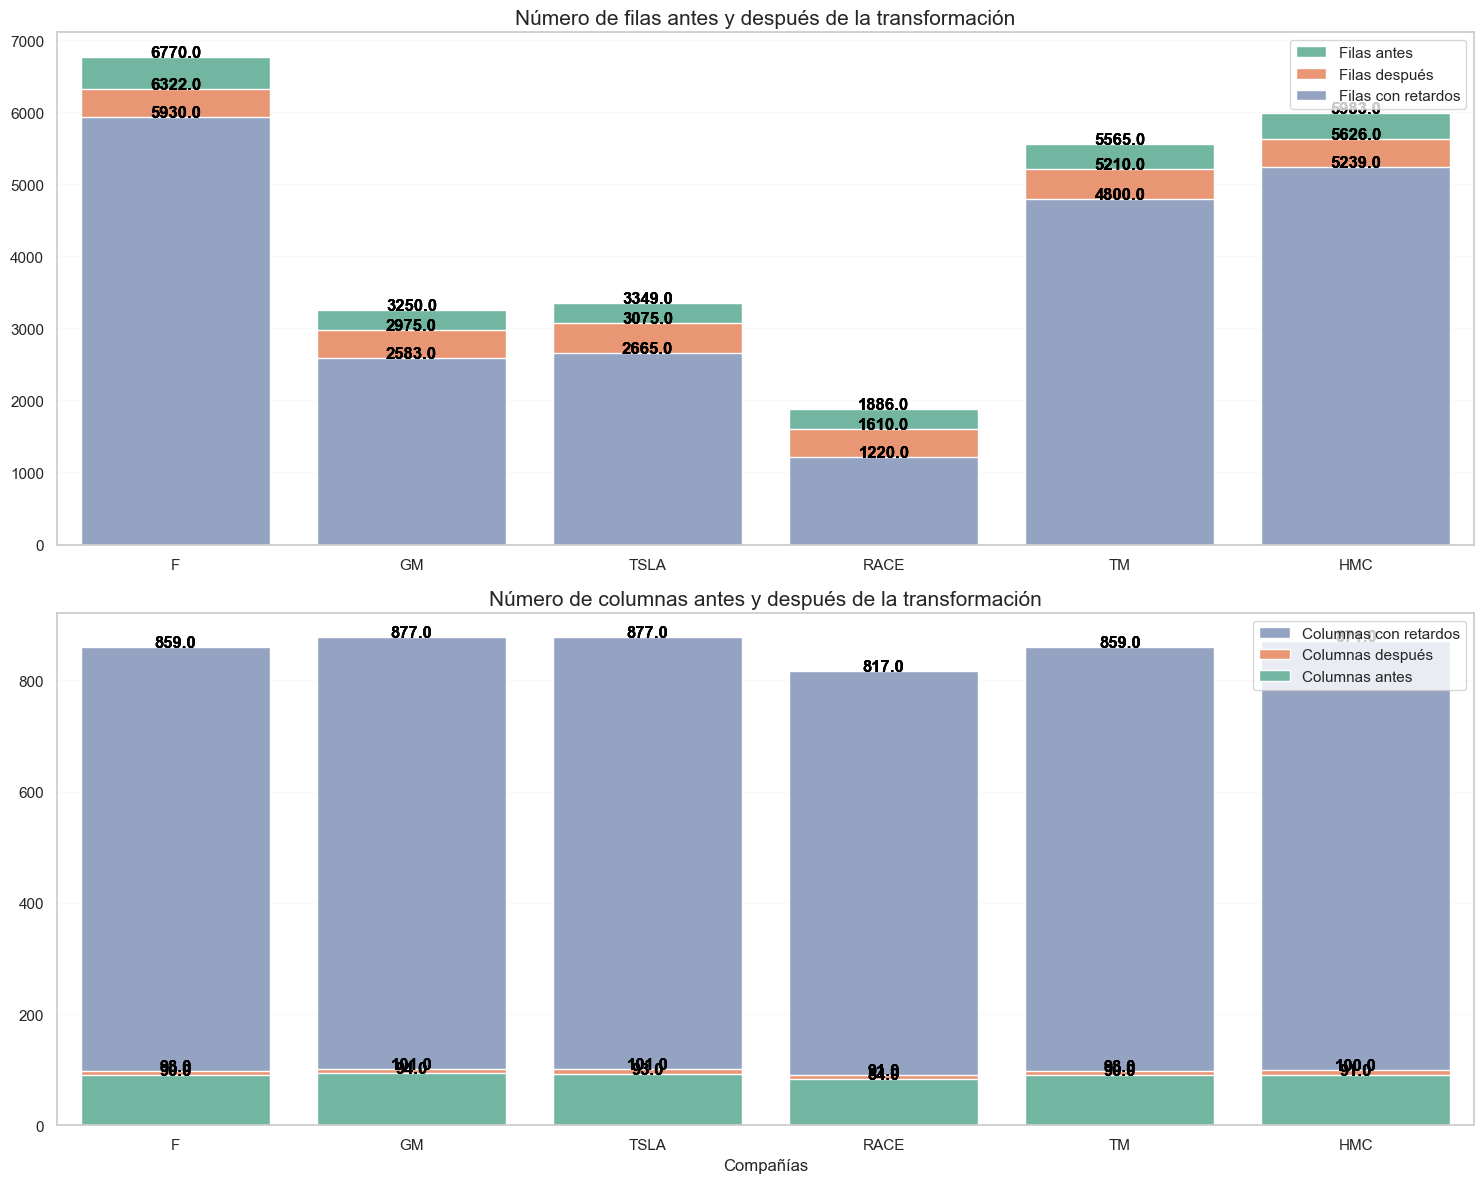

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np

# Supongamos que estos son tus datos
post_transform = {
    "F": (6322, 98),
    "GM": (2975, 101),
    "TSLA": (3075, 101),
    "RACE": (1610, 91),
    "TM": (5210, 98),
    "HMC": (5626, 100),
}


pre_transform = {
    "F": (6770, 90),
    "GM": (3250, 94),
    "TSLA": (3349, 93),
    "RACE": (1886, 84),
    "TM": (5565, 90),
    "HMC": (5983, 91),
}


lagged = {
    "F": (5930, 859),
    "GM": (2583, 877),
    "TSLA": (2665, 877),
    "RACE": (1220, 817),
    "TM": (4800, 859),
    "HMC": (5239, 871),
}
# Configuración de Seaborn
sns.set_theme(context='notebook', style='whitegrid')

# Creamos la figura y los ejes
fig, axs = plt.subplots(2, 1, figsize=(15,12))

# Definimos la paleta de colores
palette = sns.color_palette("Set2")

# Subplot para las filas
bar1 = sns.barplot(x=brands, y=[v[0] for v in pre_transform.values()], color=palette[0], ax=axs[0], label='Filas antes')
bar2 = sns.barplot(x=brands, y=[v[0] for v in post_transform.values()], color=palette[1], ax=axs[0], label='Filas después')
bar3 = sns.barplot(x=brands, y=[v[0] for v in lagged.values()], color=palette[2], ax=axs[0], label='Filas con retardos')

axs[0].set_title('Número de filas antes y después de la transformación', fontsize=15)
axs[0].legend()

# Añadir las etiquetas a las barras
for rect in bar1.patches + bar2.patches + bar3.patches:
    axs[0].text (rect.get_x() + rect.get_width() / 2, rect.get_height(), round(rect.get_height(),2), 
                 weight='bold', color='black', ha='center')

# Subplot para las columnas
bar6 = sns.barplot(x=brands, y=[v[1] for v in lagged.values()], color=palette[2], ax=axs[1], label='Columnas con retardos')
bar5 = sns.barplot(x=brands, y=[v[1] for v in post_transform.values()], color=palette[1], ax=axs[1], label='Columnas después')
bar4 = sns.barplot(x=brands, y=[v[1] for v in pre_transform.values()], color=palette[0], ax=axs[1], label='Columnas antes')



axs[1].set_title('Número de columnas antes y después de la transformación', fontsize=15)
axs[1].set_xlabel('Compañías', fontsize=12)
axs[1].legend()

# Añadir las etiquetas a las barras
for rect in bar4.patches + bar5.patches + bar6.patches:
    axs[1].text (rect.get_x() + rect.get_width() / 2, rect.get_height(), round(rect.get_height(),2), 
                 weight='bold', color='black', ha='center')

fig.tight_layout()
plt.show()


In [ ]:
import matplotlib.patches as mpatches
lstm_errors = {
    "F": {"MAE": 0.58, "RMSE": 0.87, "MAPE": 5.05, "MdAPE": 3.61},
    "GM": {"MAE": 2.24, "RMSE": 2.85, "MAPE": 5.01, "MdAPE": 4.12},
    "TSLA": {"MAE": 21.01, "RMSE": 27.78, "MAPE": 8.54, "MdAPE": 6.67},
    "RACE": {"MAE": 7.57, "RMSE": 9.59, "MAPE": 3.5, "MdAPE": 2.86},
    "TM": {"MAE": 4.13, "RMSE": 5.56, "MAPE": 2.72, "MdAPE": 2.15},
    "HMC": {"MAE": 0.79, "RMSE": 1.06, "MAPE": 2.38, "MdAPE": 2.19},
}

xgb_errors = {
    "F": {"MAE": 0.6182, "RMSE": 0.90, "MAPE": 5.2222, "MdAPE": 3.6056},
    "GM": {"MAE": 2.3939, "RMSE": 3.0255, "MAPE": 5.8508, "MdAPE": 5.0293},
    "TSLA": {"MAE": 19.7788, "RMSE": 26.3222, "MAPE": 8.5645, "MdAPE": 6.9565},
    "RACE": {"MAE": 6.783, "RMSE": 8.6689, "MAPE": 3.2052, "MdAPE": 2.4276},
    "TM": {"MAE": 3.6388, "RMSE": 4.7795, "MAPE": 2.6039, "MdAPE": 2.0301},
    "HMC": {"MAE": 0.8336, "RMSE": 1.1054, "MAPE": 3.1342, "MdAPE": 2.3447},
}

fig, ax = plt.subplots(len(xgb_errors), 4, figsize=(20, 15)) 

blue_patch = mpatches.Patch(color='blue', label='XGBoost')
orange_patch = mpatches.Patch(color='orange', label='LSTM')

for i, company in enumerate(xgb_errors.keys()):
    for j, error_type in enumerate(xgb_errors[company].keys()):
        ax[i, j].bar(["XGBoost", "LSTM"], [xgb_errors[company][error_type], lstm_errors[company][error_type]], color=['blue', 'orange'])
        ax[i, j].set_title(f"{company} - {error_type}", fontsize=14, fontweight='bold') 
        ax[i, j].set_ylabel('Error', fontsize=14, fontweight='bold') 
        ax[i, j].set_ylim(0, max(max(xgb_errors[company].values()), max(lstm_errors[company].values()))*1.1)

        ax[i, j].text("XGBoost", xgb_errors[company][error_type]/2, f"{xgb_errors[company][error_type]:.2f}", ha='center', va='bottom', fontsize=14, fontweight='bold')
        ax[i, j].text("LSTM", lstm_errors[company][error_type]/2, f"{lstm_errors[company][error_type]:.2f}", ha='center', va='bottom', fontsize=14, fontweight='bold')

fig.legend(handles=[blue_patch, orange_patch], loc='upper center', ncol=2, fontsize=18, bbox_to_anchor=(0.5, 1.02)) # Cambia fontsize a 18

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
xgb_errors = {
    "F": {"MAE": 0.5677, "RMSE": 0.8453, "MAPE": 4.8985, "MdAPE": 3.5535},
    "GM": {"MAE": 2.1405, "RMSE": 2.7513, "MAPE": 4.9727, "MdAPE": 4.1067},
    "TSLA": {"MAE": 19.0662, "RMSE": 25.2895, "MAPE": 7.7576, "MdAPE": 6.1402},
    "RACE": {"MAE": 6.7527, "RMSE": 8.3417, "MAPE": 2.9691, "MdAPE": 2.4175},
    "TM": {"MAE": 4.2097, "RMSE": 5.629, "MAPE": 2.7453, "MdAPE": 2.1716},
    "HMC": {"MAE": 0.812, "RMSE": 1.0836, "MAPE": 3.0503, "MdAPE": 2.3217},
}


lstm_errors = {
    "F": {"MAE": 0.58, "RMSE": 0.87, "MAPE": 5.05, "MdAPE": 3.61},
    "GM": {"MAE": 2.24, "RMSE": 2.85, "MAPE": 5.01, "MdAPE": 4.12},
    "TSLA": {"MAE": 21.01, "RMSE": 27.78, "MAPE": 8.54, "MdAPE": 6.67},
    "RACE": {"MAE": 7.57, "RMSE": 9.59, "MAPE": 3.5, "MdAPE": 2.86},
    "TM": {"MAE": 4.13, "RMSE": 5.56, "MAPE": 2.72, "MdAPE": 2.15},
    "HMC": {"MAE": 0.79, "RMSE": 1.06, "MAPE": 2.38, "MdAPE": 2.19},
}


fig, ax = plt.subplots(len(xgb_errors), 4, figsize=(20, 15)) # Ajuste del tamaño de la figura

# Definición de la leyenda común
blue_patch = mpatches.Patch(color='blue', label='XGBoost')
orange_patch = mpatches.Patch(color='orange', label='LSTM')

for i, company in enumerate(xgb_errors.keys()):
    for j, error_type in enumerate(xgb_errors[company].keys()):
        ax[i, j].bar(["XGBoost", "LSTM"], [xgb_errors[company][error_type], lstm_errors[company][error_type]], color=['blue', 'orange'])
        ax[i, j].set_title(f"{company} - {error_type}", fontsize=14, fontweight='bold') # Texto de título en negrita
        ax[i, j].set_ylabel('Error', fontsize=14, fontweight='bold') # Texto del eje y en negrita
        ax[i, j].set_ylim(0, max(max(xgb_errors[company].values()), max(lstm_errors[company].values()))*1.1)

        # Añadir valores de error encima de las barras con tamaño de fuente ajustable y en negrita
        ax[i, j].text("XGBoost", xgb_errors[company][error_type], f"{xgb_errors[company][error_type]:.2f}", ha='center', va='bottom', fontsize=25, fontweight='bold')
        ax[i, j].text("LSTM", lstm_errors[company][error_type], f"{lstm_errors[company][error_type]:.2f}", ha='center', va='bottom', fontsize=25, fontweight='bold')

# Colocación de la leyenda común
fig.legend(handles=[blue_patch, orange_patch], loc='upper center', ncol=2, fontsize=18, bbox_to_anchor=(0.5, 1.02))

plt.tight_layout()
plt.show()
